In [1]:
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import cm
plt.style.use('ggplot')
import torch
from torch import nn
from torch.utils.data import random_split,  DataLoader,  TensorDataset
from torch.distributions import multivariate_normal,  binomial
from sklearn import datasets
import numpy as np
from torch.autograd import Variable
import ipdb
from sklearn.mixture import GaussianMixture
from torchdiffeq import odeint,  odeint_adjoint
from collections import OrderedDict
from tqdm import tqdm
random_seed = 0
n_samples = 400
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
np.random.seed(random_seed)
plt.style.use('seaborn-talk')

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"


# Utils

In [101]:
def phase_evol(phases, masks, save_name=None):
        phases = np.squeeze(np.array(phases, dtype=np.float32))
        phases = (phases % ((2*np.pi) + 2*np.pi)) % (2*np.pi)
        if masks is not None:
            group_num = masks.shape[1]
            annot_bool = [True] * group_num
            colors = {}
            for num in range(group_num):
                mean_angle = np.arctan2((np.sin(phases[-1]) * masks[0][num]).sum(),
                                        (np.cos(phases[-1]) * masks[0][num]).sum() + 1e-6)
                colors[num] = num*50#(mean_angle + 2 * np.pi) % (2 * np.pi) / (2 * np.pi)
            for i in range(phases.shape[1]):
                for num in range(group_num):
                    if masks[0][num][i]:
                        plt.plot(phases[:, i], color=plt.cm.hsv(colors[num]), alpha=0.5)
                        if annot_bool[num]:
                            plt.text(phases.shape[0] + 0.01, phases[-1, i], 'group{}'.format(num+1),
                                     horizontalalignment='left', size='small', color=plt.cm.hsv(colors[num]))
                            annot_bool[num] = False
            plt.xlabel('Time')
            plt.ylabel('Phase')
            plt.title('Phase Evolution')
            plt.ylim([0,2*np.pi])
        else:
            for i in range(phases.shape[1]):
                plt.plot(phases[:, i])
            plt.xlabel('Time')
            plt.ylabel('Phase')
            plt.title('Phase Evolution')
        plt.tight_layout()
        if save_name is not None:
            plt.savefig(save_name + '.png')
        else:
            plt.show()
        plt.close()
        

def phase_evol_ax(ax, phases, masks, save_name=None):
    phases = np.squeeze(np.array(phases, dtype=np.float32))
    phases = (phases % ((2*np.pi) + 2*np.pi)) % (2*np.pi)
    if masks is not None:
        group_num = masks.shape[1]
        annot_bool = [True] * group_num
        colors = {}
        for num in range(group_num):
            mean_angle = np.arctan2((np.sin(phases[-1]) * masks[0][num]).sum(),
                                    (np.cos(phases[-1]) * masks[0][num]).sum() + 1e-6)
            colors[num] = num*50#(mean_angle + 2 * np.pi) % (2 * np.pi) / (2 * np.pi)
        for i in range(phases.shape[1]):
            for num in range(group_num):
                if masks[0][num][i]:
                    ax.plot(phases[:, i], color=plt.cm.hsv(colors[num]), alpha=0.5)
                    if annot_bool[num]:
                        ax.text(phases.shape[0] + 0.01, phases[-1, i], 'group{}'.format(num+1),
                                 horizontalalignment='left', size='small', color=plt.cm.hsv(colors[num]))
                        annot_bool[num] = False
        ax.set_xlabel('Time')
        ax.set_ylabel('Phase')
        ax.set_title('Phase Evolution')
        ax.set_ylim([0,2*np.pi])
    else:
        for i in range(phases.shape[1]):
            ax.set_plot(phases[:, i])
        ax.set_xlabel('Time')
        ax.set_ylabel('Phase')
        ax.set_title('Phase Evolution')


class Moons(object):
    def __init__(self, noise = 0.05, random_state=1):
        self.noise = noise
        self.random_state = random_state
        self.n_components = 2

    def sample(self, n_samples=400):
        x, y = datasets.make_moons(n_samples,
                            noise = self.noise,
                             random_state=self.random_state)
        return [torch.tensor(x), torch.tensor(y)]

    def train_test(selfn_samples_trainn_samples_test):
        return self.sample(n_samples_train), self.sample(n_samples_test)
    
        
class Circles(object):
    def __init__(selffactor = 0.5, random_state=1):
        self.factor = factor
        self.random_state = random_state
        self.n_components = 2

    def sample(self, n_samples=400):
        x, y = datasets.make_circles(n_samples,
                            factor = self.factor,
                             random_state=self.random_state)
        return [torch.tensor(x), torch.tensor(y)]

    def train_test(selfn_samples_trainn_samples_test):
        return self.sample(n_samples_train), self.sample(n_samples_test)

class GMM(object):
    def __init__(self, n_components, centroids, cov_matrices):
        self.n_components = n_components
        self.centroids = centroids
        self.cov_matrices = cov_matrices

    def one_sampling(self,statistics):
        return np.random.multivariate_normal(statistics[0], statistics[1])

    def sample(self, n_samples):
        idx = np.random.randint(0, self.n_components,n_samples)
        list_stat = [[self.centroids[i],self.cov_matrices[i]] for i in idx]
        return [torch.tensor((np.vstack(list(map(self.one_sampling,list_stat))))), torch.tensor(idx)]

    def train_test(selfn_samples_trainn_samples_test):
        return self.sample(n_samples_train), self.sample(n_samples_test)
    
class fixed_graph(object):
    def __init__(self, n_nodes, n_groups):
        self.n_components = n_groups
        self.n_nodes = n_nodes

    def sample(self,zzz):
        n_group_card = self.n_nodes//self.n_components
        n_group_rest = self.n_nodes%self.n_components
        idx = np.concatenate([np.tile(np.arange(self.n_components),(n_group_card)),np.arange(n_group_rest)])
        return [torch.FloatTensor(()), torch.tensor(idx)]
    
class Spirals(object):
    def __init__(self, noise):
        self.noise = noise
        self.n_components = 2


    def sample(self, n_samples):
        n_samples=int(n_samples/2)
        theta = np.sqrt(np.random.rand(n_samples))*2*np.pi # np.linspace(0,2*pi,100)
        r_a = 2*theta + np.pi
        data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
        x_a = data_a + np.random.randn(n_samples,2)*self.noise

        r_b = -2*theta - np.pi
        data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
        x_b = data_b + np.random.randn(n_samples,2)*self.noise
        
        res_a = np.append(x_a, np.zeros((n_samples,1)), axis=1)
        res_b = np.append(x_b, np.ones((n_samples,1)), axis=1)

        res = torch.tensor(np.append(res_a, res_b, axis=0)).float()
        return [res[:,:2],res[:,2].long()]

### Loss function

In [3]:
def circular_moments_batch(phases, masks, lasts=50, split = False, burn_in_prop=.5):
    num_groups = masks.shape[0]
    group_size = masks.sum(1)
    group_size = torch.where(group_size == 0, torch.ones_like(group_size), group_size)
    T = phases.shape[0]
    
    burn_in_steps = int(burn_in_prop * T)
    masked_phases = phases.unsqueeze(1) * masks
    xx = torch.where(masks.bool(), torch.cos(masked_phases), torch.zeros_like(masked_phases))
    yy = torch.where(masks.bool(), torch.sin(masked_phases), torch.zeros_like(masked_phases))
    go = torch.sqrt((xx.sum(-1))**2 + (yy.sum(-1))**2) / group_size
    synch = 1 - go.sum(-1)/num_groups

    mean_angles = torch.atan2(yy.sum(-1),xx.sum(-1))
    desynch = 0
    for m in np.arange(1, int(np.floor(num_groups/2.))+1):
#         K_m = 1 if m < int(np.floor(num_groups/2.)) + 1 else -1
        desynch += (1.0 / (2* num_groups * m**2)) * (torch.cos(m*mean_angles).sum(-1)**2 + torch.sin(m*mean_angles).sum(-1)**2)
        
    #for m in range(1,num_groups):
    #    desynch += (1.0 / 2*num_groups*m**2) * (torch.cos(m*mean_angles).sum(-1)**2 + torch.sin(m*mean_angles).sum(-1)**2)
    #desynch += (1.0 / 2*num_groups*num_groups**2) * (torch.cos(num_groups*mean_angles).sum(-1)**2 + torch.sin(num_groups*mean_angles).sum(-1)**2)
        
    loss = (synch + desynch)
    
    if split == True:
        return loss[burn_in_steps:,...].mean(), synch[burn_in_steps:,...].mean(), desynch[burn_in_steps:,...].mean()
    else:
        return loss[burn_in_steps:,...].mean()

### Adjoint method

In [4]:
class KuraODE(nn.Module):
        
    """
    torch.nn.Module that defines the infinitesimal evolution of the ODE : df/dt = module(t,\\theta),
    - Handles batchs of images by flattening the batch dim and treat everything as a single ODE,
    - Requires the update of the couplings parameters at every call to get the gradient d(couplings)/dL,
    """

    def __init__(self):
        super(KuraODE, self).__init__()
        #self.couplings = torch.nn.Parameter(torch.eye(1),requires_grad=True) #placeholder,

    def update(self, couplings):
        self.couplings = torch.nn.Parameter(couplings,requires_grad=True)
        self.nfe = 0

    def forward(self, t, phase):
        self.nfe+=1
        phase = phase.reshape(self.couplings.shape[0],-1).float()
        n = self.couplings.shape[0]
        delta_phase = (self.couplings.unsqueeze(0)@torch.sin(phase).float() * torch.cos(phase) - 
        self.couplings.unsqueeze(0)@torch.cos(phase).float() * torch.sin(phase)) / n 

        return delta_phase.squeeze(-1)

In [331]:
class Kuramoto_features(nn.Module):

    def __init__(self,
                 batch_size = 32,
                 num_hid_units = 32,
                 num_hid_layers = 1,
                 input_size = 2,
                 feature_size = 10,
                 steps=100,
                 time=1500,
                 alpha=1e-1,
                 device='cpu',
                 adjoint=True,
                 gain=1.,
                 recenter=.1,
                 reweight=1.0,
                 postprocess='mathieu',
                 batch_norm=False):

        super(Kuramoto_features, self).__init__()

        self.postprocess = postprocess
        
        #Integration parameters
        self.adjoint=adjoint
        self.steps = steps
        self.time = time
        self.alpha=alpha
        self.integration_time =  torch.linspace(0., self.time, self.steps).float()
        self.ODEDynamic = KuraODE()
        self.tol = 1e-5
        self.atol = 1e-5
        self.max_steps = 1000

        #Problem dimensions
        self.batch_size = batch_size
        self.indim = input_size
        if self.postprocess == 'mathieu':
            self.outdim = feature_size
#         elif self.postprocess == 'symmetric':
#             self.triu_ind = torch.triu_indices(self.indim, self.indim, offset=1)
#             self.outdim = int((self.indim * (self.indim - 1) )/ 2)
        self.device = device
        self.gain = gain
        self.recenter = recenter
        self.reweight = reweight

        # Definition of couplings
        #self.couplings = torch.nn.Parameter(torch.rand(batch_size,batch_size) - .5,requires_grad=True)

        # Definition of coupling inference model
        if batch_norm:
            layer_list = [torch.nn.Linear(self.indim, num_hid_units), torch.nn.ReLU(), torch.nn.BatchNorm1d(num_hid_units)] + \
            num_hid_layers * [torch.nn.Linear(num_hid_units,num_hid_units),
                          torch.nn.ReLU(), torch.nn.BatchNorm1d(num_hid_units)] + [torch.nn.Linear(num_hid_units,self.outdim)]
        else:
            layer_list = [torch.nn.Linear(self.indim, num_hid_units), torch.nn.ReLU()] + num_hid_layers * [torch.nn.Linear(num_hid_units,num_hid_units),
                          torch.nn.ReLU()] + [torch.nn.Linear(num_hid_units,self.outdim)]
        self.layers = torch.nn.ModuleList(layer_list)
        
        for layer in self.layers:
            try :
                #torch.nn.init.orthogonal_(layer.weight, gain=1)
                #torch.nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='tanh')
                torch.nn.init.xavier_normal_(layer.weight, gain=self.gain)
                #torch.nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='tanh')
            except:
                pass

    def sample_couplings(self, batches, num_samples=64):
        all_couplings = []
        for batch in batches:
            all_couplings.append(self.layers(batch.reshape(1,-1)).reshape(self.batch_size,self.batch_size).detach())
        all_couplings = torch.stack(all_couplings).reshape(-1).numpy()
        return all_couplings

    def forward(self,init_phase, x, method='euler'):
        #Infer couplings 
        for layer in self.layers:
            x = layer(x)
        features = x
#         features = self.layers(x)
        #print(features[:10])
        if self.postprocess == 'mathieu':
            features = features / torch.pow(features,2).sum(-1).unsqueeze(1)
            couplings = features @ features.T
            couplings = self.reweight * (couplings / torch.pow(couplings,2).sum(-1).unsqueeze(1)) - self.recenter
#             couplings = couplings / torch.pow(couplings,2).sum() - .1
        #couplings = couplings - torch.mean(couplings)
        self.couplings = couplings

        self.ODEDynamic.update(self.couplings)

        #Run Dynamic with adaptative solver
        if self.adjoint:
            trajectory = odeint_adjoint(self.ODEDynamic, init_phase, self.integration_time,
                                   rtol=self.tol, atol=self.atol, method=method)
        else:
            trajectory = []
            phase = init_phase
            for t in range(self.T):
                phase = phase + self.alpha*self.ODEDynamic.forward(t, phase)
                trajectory.append(phase)
            trajectory = torch.stack(trajectory)

        return trajectory, couplings

In [287]:
class KuraTrainer(object):
        def __init__(self, model, data_generator, batch_size, LossFunc,
                     num_features=32, rescale=1.0):
            super(KuraTrainer, self).__init__()
            self.data_generator = data_generator
            self.batch_size = batch_size
            self.LossFunc = LossFunc
            self.num_features=num_features
            self.model = model
            self.rescale = rescale
            
        def init_phase(self,batch_size):
            #self.init = torch.zeros((batch_size,)).float().unsqueeze(0)
            self.init = torch.normal(np.pi,1,(batch_size,)).float().unsqueeze(0)
            #self.init = torch.FloatTensor(batch_size,).uniform_(0, 2*np.pi).unsqueeze(0)
            return self.init
            #return torch.normal(np.pi,0.05,(batch_size,)).float().unsqueeze(0)
        
        def plot_data(self,num_points):
            a, idx = self.data_generator.sample(num_points)
            plt.scatter(a[:,0],a[:,1],c=idx)
            plt.show()
            
        def train_same_batch(self,gradient_steps=50,lr=0.1, alpha=.1,
                             normalized=False, eps=1e-12,num_loss=0,burn_in_prop=.5, verbose=0, method='euler'):
            self.lh = []
            opt = torch.optim.Adam(self.model.parameters(), lr=lr)
            self.init = self.init_phase(self.batch_size)
            batch, idx = self.data_generator.sample(self.batch_size)
            self.batch = batch.float()
            self.idx = idx.float()
            masks = torch.FloatTensor(self.batch_size,self.data_generator.n_components).zero_()
            masks.scatter_(1,idx.unsqueeze(1),1).transpose_(1,0)
            
            for _ in range(gradient_steps):
                start = time.time()
                
                init_phase = self.init #self.init_phase(self.batch_size)
                
                #Training by gradient descent via adjoint sensitivity method
                opt.zero_grad()
                phase, couplings = self.model(self.init, self.batch, method=method)
                loss = LossFunc(phase, masks,split=True, burn_in_prop=burn_in_prop)
                self.lh.append(loss[num_loss].detach().numpy())
                loss[num_loss].backward()
                self.model.couplings.backward(gradient=self.model.ODEDynamic.couplings.grad)
                opt.step()
                stop = time.time()
                if verbose > 0: 
                    if _ % 10 == 0: 
                        print('Step: {}. Time: {}. Loss: {}'.format(_, np.round(stop-start,4), loss.detach().cpu().numpy()))
                        print('Gradient norm: {}\n'.format(torch.pow(self.model.ODEDynamic.couplings.grad,2).sum().detach().cpu().numpy()))
            return
        
        def train(self,gradient_steps=50,lr=0.1, alpha=.1, normalized=False,
                  eps=1e-12,num_loss=0,burn_in_prop=.5, verbose=0, optimizer='Adam', momentum=.5, method='euler'):
            self.lh = []
            if optimizer == 'Adam':
                opt = torch.optim.Adam(self.model.parameters(), lr=lr)
            elif optimizer == 'SGD':
                opt = torch.optim.SGD(self.model.parameters(), lr=lr, momentum=momentum)

            for _ in range(gradient_steps):
                start = time.time()
                with torch.no_grad():
                    batch, idx = self.data_generator.sample(self.batch_size)
                    self.batch = self.rescale * batch.float()
                    self.idx = idx.float()
                    masks = torch.FloatTensor(self.batch_size,self.data_generator.n_components).zero_()
                    masks.scatter_(1,idx.unsqueeze(1),1).transpose_(1,0)
                    init_phase = self.init_phase(self.batch_size) #self.init_phase(self.batch_size)

                #Training by gradient descent via adjoint sensitivity method
                opt.zero_grad()
                phase, couplings = self.model(self.init, self.batch, method=method)
                loss = LossFunc(phase, masks,split=True, burn_in_prop=burn_in_prop)
                self.lh.append(loss[num_loss].detach().numpy())
                loss[num_loss].backward()
                self.model.couplings.backward(gradient=self.model.ODEDynamic.couplings.grad)
                opt.step()
                stop = time.time()
                if verbose > 0: 
                    if _ % 10 == 0: 
                        print('Step: {}. Time: {}. Loss: {}'.format(_, np.round(stop-start,4), loss[0].detach().cpu().numpy()))
                        print('Gradient norm: {}\n'.format(torch.pow(self.model.ODEDynamic.couplings.grad,2).sum().detach().cpu().numpy()))
            return

# GMM

In [303]:
device='cuda'
num_seeds = 1
all_losses = []
all_init_phase = []
all_init_coupling = []
bs = 100
optimizer='Adam' #Adam
num_hid_units=100
num_hid_layers=1
gradient_steps=600
lr=5e-4 #5e-4
momentum=0.5
for seed in range(num_seeds):
    print(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    Model = Kuramoto_features(batch_size = bs, num_hid_units=num_hid_units, num_hid_layers=num_hid_layers,
                              input_size=2, feature_size=10, device=device, adjoint=True,gain=0.5)
    gmm = GMM(n_components=5, centroids=[[3,-3],[4,8],[-3,3],[-2,-5],[0,10]], cov_matrices=20*np.array([0.05*np.eye(2),0.02*np.diag([1,5]),0.02*np.eye(2),0.01*np.eye(2),0.01*np.eye(2)]))
#   gmm = GMM(n_components=2, centroids=[[2,-2],[-2,2]], cov_matrices=[0.5*np.eye(2),0.2*np.eye(2)])
#   gmm = GMM(n_components=3, centroids=[[2,-2],[4,4],[-3,3]], cov_matrices=[0.05*np.eye(2),0.02*np.diag([1,5]),.02*np.eye(2)])
    LossFunc = circular_moments_batch
    Trainer = KuraTrainer(Model, gmm, LossFunc=LossFunc, batch_size=bs)
    #all_init_coupling.append(Model.couplings.detach().clone().numpy())
    Trainer.train(gradient_steps=gradient_steps,lr=lr,num_loss=0, burn_in_prop=0, verbose=1,
                  optimizer=optimizer, momentum=momentum)
    all_init_phase.append(Trainer.init)
    all_losses.append(Trainer.lh[-1])

0
Step: 0. Time: 0.3744. Loss: 0.9236361980438232
Gradient norm: 794.041259765625

Step: 10. Time: 0.3246. Loss: 0.9753559827804565
Gradient norm: 167.44802856445312

Step: 20. Time: 0.3482. Loss: 1.1379764080047607
Gradient norm: 1227.2366943359375

Step: 30. Time: 0.2704. Loss: 1.338194727897644
Gradient norm: 2274.47509765625

Step: 40. Time: 0.3675. Loss: 1.0014835596084595
Gradient norm: 455.61920166015625

Step: 50. Time: 0.3394. Loss: 0.9685109853744507
Gradient norm: 189.32901000976562

Step: 60. Time: 0.3626. Loss: 0.9705314636230469
Gradient norm: 156.99365234375

Step: 70. Time: 0.2663. Loss: 0.9789317846298218
Gradient norm: 135.62477111816406

Step: 80. Time: 0.2956. Loss: 0.8325208425521851
Gradient norm: 104.23351287841797

Step: 90. Time: 0.3068. Loss: 0.6795685291290283
Gradient norm: 89.74404907226562

Step: 100. Time: 0.3037. Loss: 0.9012110233306885
Gradient norm: 195.63868713378906

Step: 110. Time: 0.2726. Loss: 0.9283885955810547
Gradient norm: 2.534270763397217


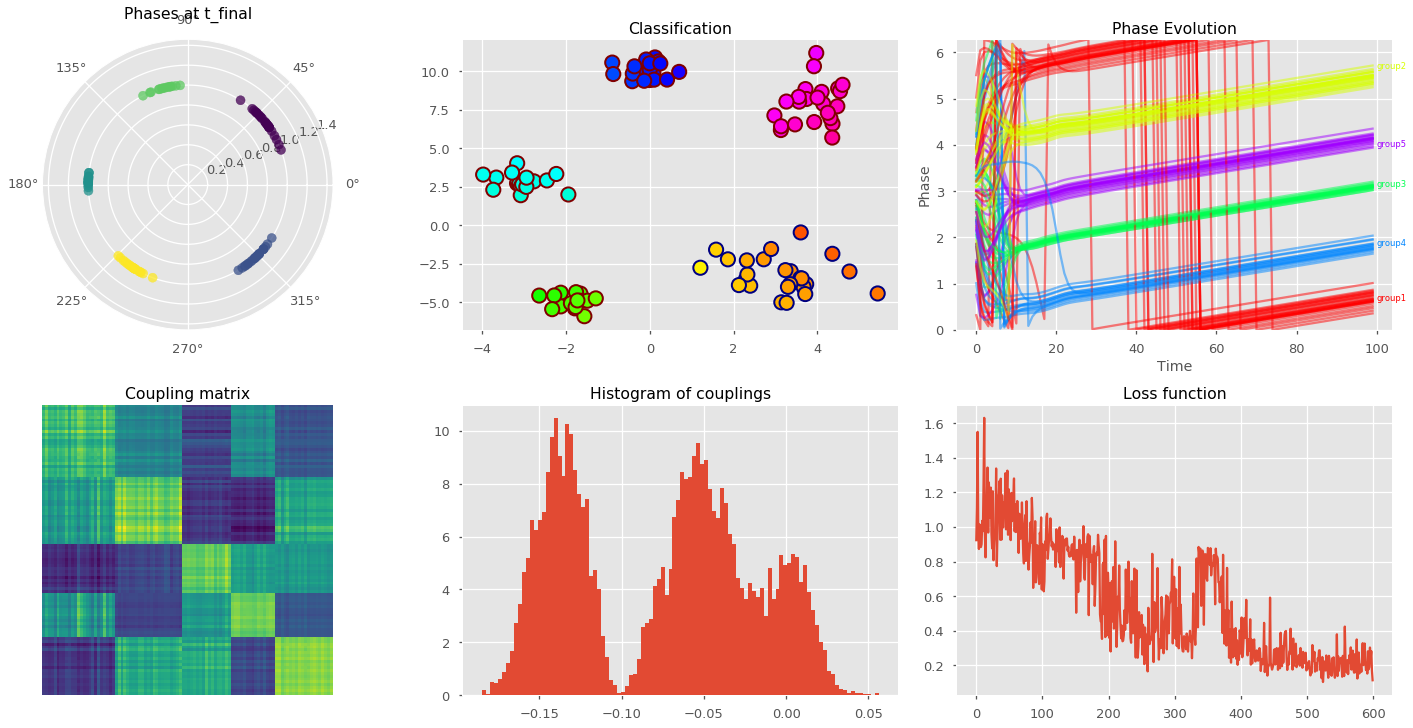

In [304]:
m=5
# LossFunc = circular_moments_batch
# bs = 100
# Trainer = KuraTrainer(Model, gmm, LossFunc=LossFunc, batch_size=bs)
a = Trainer.batch
idx = Trainer.idx
sorted_idx = np.argsort(idx)
masks = torch.FloatTensor(bs,m).zero_()
masks.scatter_(1,idx.unsqueeze(1).long(),1).transpose_(1,0)
ecolors = [cm.jet(x*10) for x in idx]
# init_phase = torch.normal(np.pi,1,(bs,)).float().unsqueeze(0)
init_phase = Trainer.init
#init_phase = torch.FloatTensor(bs,).uniform_(0, 2*np.pi).unsqueeze(0)
# Trainer.init_phase(bs)
phase, couplings  = Model(Trainer.init,a)


fig = plt.figure(figsize=(20,10),constrained_layout=True)
spec4 = fig.add_gridspec(ncols=3, nrows=2)
ax = fig.add_subplot(spec4[0, 0], polar=True)
ax.set_title('Phases at t_final')
ax.scatter(phase[-1].squeeze(0).detach().numpy(), np.ones(len(idx)), c=idx, alpha=0.75)
ax = fig.add_subplot(spec4[0, 1])
ax.set_title('Classification')
ecolors = [cm.jet(x*10) for x in idx]
colors = [cm.hsv(x) for x in (phase[-1].squeeze().detach().numpy()%(2*np.pi))/(2*np.pi)]
ax.scatter(a[:,0],a[:,1],c=colors,edgecolors=ecolors,linewidth=2,s=200)
ax = fig.add_subplot(spec4[1,0])
ax.set_title('Coupling matrix')

sorted_couplings = couplings[sorted_idx,:]
sorted_couplings = sorted_couplings[:,sorted_idx].detach().cpu().numpy()
# sorted_couplings = 1.0*(sorted_couplings > sorted_couplings.mean())
im = ax.imshow(sorted_couplings)
# fig.colorbar(im, cax=ax)
plt.axis('off')
ax.grid(b=None)
ax = fig.add_subplot(spec4[1,1])
ax.set_title('Histogram of couplings')
ax.hist(couplings.reshape(-1).detach().numpy(), 100, density=True)
ax = fig.add_subplot(spec4[0,2])
phase_evol_ax(ax,phase.detach(),masks.unsqueeze(0).data.numpy())
ax = fig.add_subplot(spec4[1,2])
ax.set_title('Loss function')
ax.plot(Trainer.lh)
plt.savefig('circles classification',dpi=200)
plt.show()

# Moons 

In [309]:
device='cuda'
num_seeds = 1
all_losses = []
all_init_phase = []
all_init_coupling = []
bs = 100
optimizer='SGD'
momentum=.25
num_hid_layers=2
num_hid_units=256
rescale=5.0

for seed in range(num_seeds):
    print(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    Model = Kuramoto_features(batch_size = bs,
                              num_hid_units = num_hid_units,num_hid_layers=num_hid_layers,
                              input_size=2, feature_size=10, device=device, adjoint=True, gain=1.0)
    gmm = Moons(noise = 0.05, random_state=1)

    LossFunc = circular_moments_batch
    Trainer = KuraTrainer(Model, gmm, LossFunc=LossFunc, batch_size=bs, rescale=rescale)
    #all_init_coupling.append(Model.couplings.detach().clone().numpy())
    Trainer.train(gradient_steps=425,lr=5e-3,num_loss=0, burn_in_prop=0, verbose=1, optimizer=optimizer, momentum=momentum)
    all_init_phase.append(Trainer.init)
    all_losses.append(Trainer.lh[-1])

0
Step: 0. Time: 0.2579. Loss: 0.9253537654876709
Gradient norm: 16.367046356201172

Step: 10. Time: 0.2545. Loss: 0.7939547896385193
Gradient norm: 560.4404907226562

Step: 20. Time: 0.2458. Loss: 0.5551454424858093
Gradient norm: 93.19227600097656

Step: 30. Time: 0.2919. Loss: 0.4579143226146698
Gradient norm: 451.6495361328125

Step: 40. Time: 0.2403. Loss: 0.4751027822494507
Gradient norm: 15.777950286865234

Step: 50. Time: 0.2243. Loss: 0.3149641156196594
Gradient norm: 1.3564398288726807

Step: 60. Time: 0.2229. Loss: 0.3039231300354004
Gradient norm: 2.980222463607788

Step: 70. Time: 0.2482. Loss: 0.2587881088256836
Gradient norm: 0.10303984582424164

Step: 80. Time: 0.2306. Loss: 0.24089311063289642
Gradient norm: 0.18262743949890137

Step: 90. Time: 0.2284. Loss: 0.23127050697803497
Gradient norm: 0.09536565095186234

Step: 100. Time: 0.2687. Loss: 0.286292165517807
Gradient norm: 0.45611241459846497

Step: 110. Time: 0.2798. Loss: 0.22808998823165894
Gradient norm: 0.15450

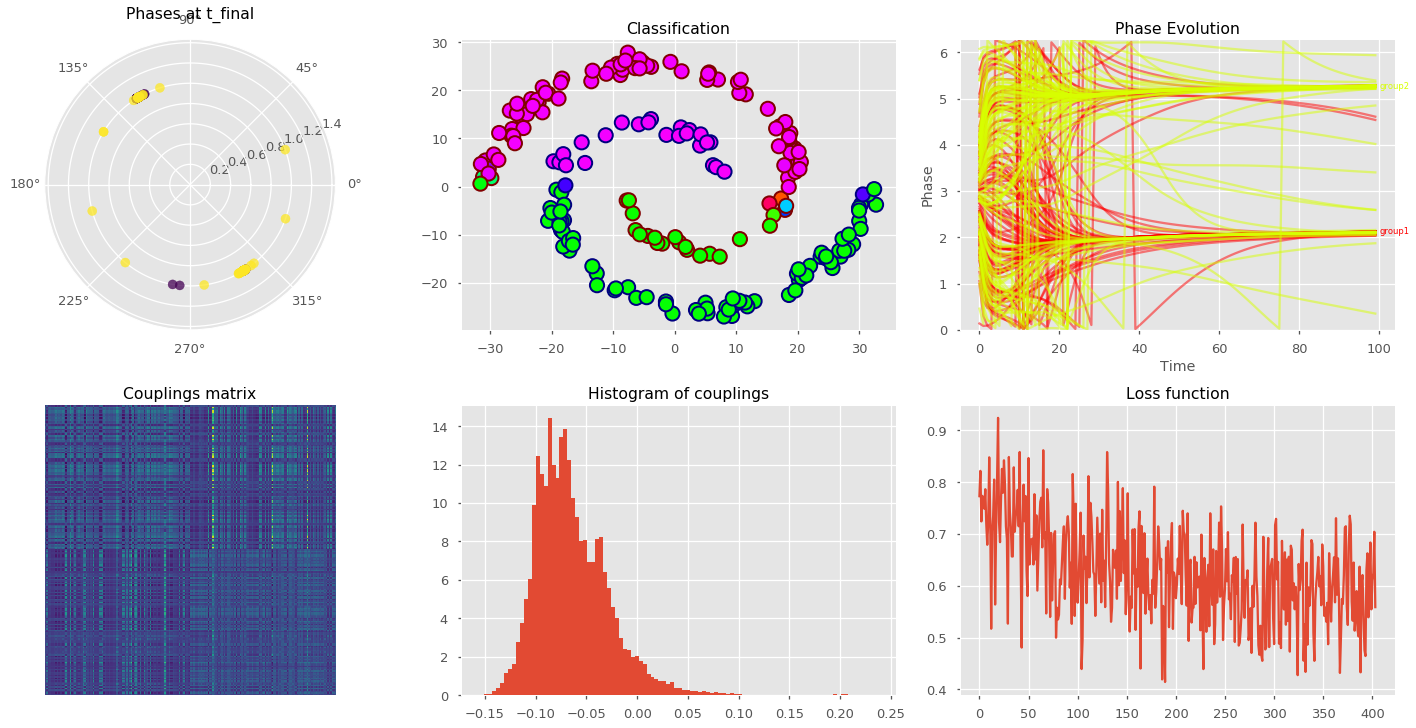

In [329]:
a = Trainer.batch
idx = Trainer.idx
sorted_idx = np.argsort(idx)
masks = torch.FloatTensor(bs,m).zero_()
masks.scatter_(1,idx.unsqueeze(1).long(),1).transpose_(1,0)
ecolors = [cm.jet(x*10) for x in idx]
# init_phase = torch.normal(np.pi,1,(bs,)).float().unsqueeze(0)
init_phase = Trainer.init
#init_phase = torch.FloatTensor(bs,).uniform_(0, 2*np.pi).unsqueeze(0)
# Trainer.init_phase(bs)
phase, couplings  = Model(Trainer.init,a)


fig = plt.figure(figsize=(20,10),constrained_layout=True)
spec4 = fig.add_gridspec(ncols=3, nrows=2)
ax = fig.add_subplot(spec4[0, 0], polar=True)
ax.set_title('Phases at t_final')
ax.scatter(phase[-1].squeeze(0).detach().numpy(), np.ones(len(idx)), c=idx, alpha=0.75)
ax = fig.add_subplot(spec4[0, 1])
ax.set_title('Classification')
ecolors = [cm.jet(x*10) for x in idx]
colors = [cm.hsv(x) for x in (phase[-1].squeeze().detach().numpy()%(2*np.pi))/(2*np.pi)]
ax.scatter(a[:,0],a[:,1],c=colors,edgecolors=ecolors,linewidth=2,s=200)
ax = fig.add_subplot(spec4[1,0])
ax.set_title('Couplings matrix')
sorted_couplings = couplings[sorted_idx,:]
sorted_couplings = sorted_couplings[:,sorted_idx].detach().numpy()
ax.imshow(sorted_couplings)
#ax.colorbar()
plt.axis('off')
ax.grid(b=None)
ax = fig.add_subplot(spec4[1,1])
ax.set_title('Histogram of couplings')
ax.hist(couplings.reshape(-1).detach().numpy(), 100, density=True)
ax = fig.add_subplot(spec4[0,2])
phase_evol_ax(ax,phase.detach(),masks.unsqueeze(0).data.numpy())
ax = fig.add_subplot(spec4[1,2])
ax.set_title('Loss function')
ax.plot(Trainer.lh)
plt.savefig('circles classification',dpi=200)
plt.show()

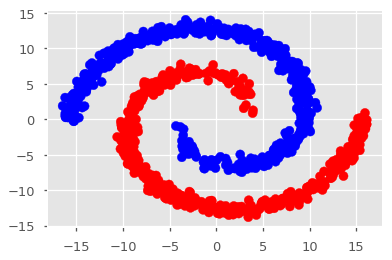

In [25]:
gmm = Spirals(noise=.5)
samples, labels = gmm.sample(1000)
colors = np.where(labels, 'b', 'r')
plt.scatter(samples[:,0], samples[:,1], color=colors)
plt.show()
plt.close()

# Spirals

In [ ]:
device = 'cuda'
num_seeds = 1
all_losses = []
all_init_phase = []
all_init_coupling = []
bs = 200
optimizer='SGD'
momentum=0.0
lr=1e-4
num_hid_layers=1
num_hid_units=256
rescale=1.0
feature_size=10
recenter = 0.1
reweight = 1.0
method='euler'
gradient_steps=600
batch_norm=True

for seed in range(num_seeds):
    print(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    Model = Kuramoto_features(batch_size = bs,
                              num_hid_units = num_hid_units,num_hid_layers=num_hid_layers,
                              input_size=2, feature_size=feature_size, device=device, adjoint=True,
                              gain=1.0, recenter=recenter, reweight=reweight, batch_norm=batch_norm)
    ipdb.set_trace()
    gmm = Spirals(noise = 0.5)
    LossFunc = circular_moments_batch
    Trainer = KuraTrainer(Model, gmm, LossFunc=LossFunc, batch_size=bs, rescale=rescale)
    #all_init_coupling.append(Model.couplings.detach().clone().numpy())
    Trainer.train(gradient_steps=gradient_steps,lr=lr,num_loss=0, burn_in_prop=0, verbose=1,
                  optimizer=optimizer, momentum=momentum, method=method)
    all_init_phase.append(Trainer.init)
    all_losses.append(Trainer.lh[-1])

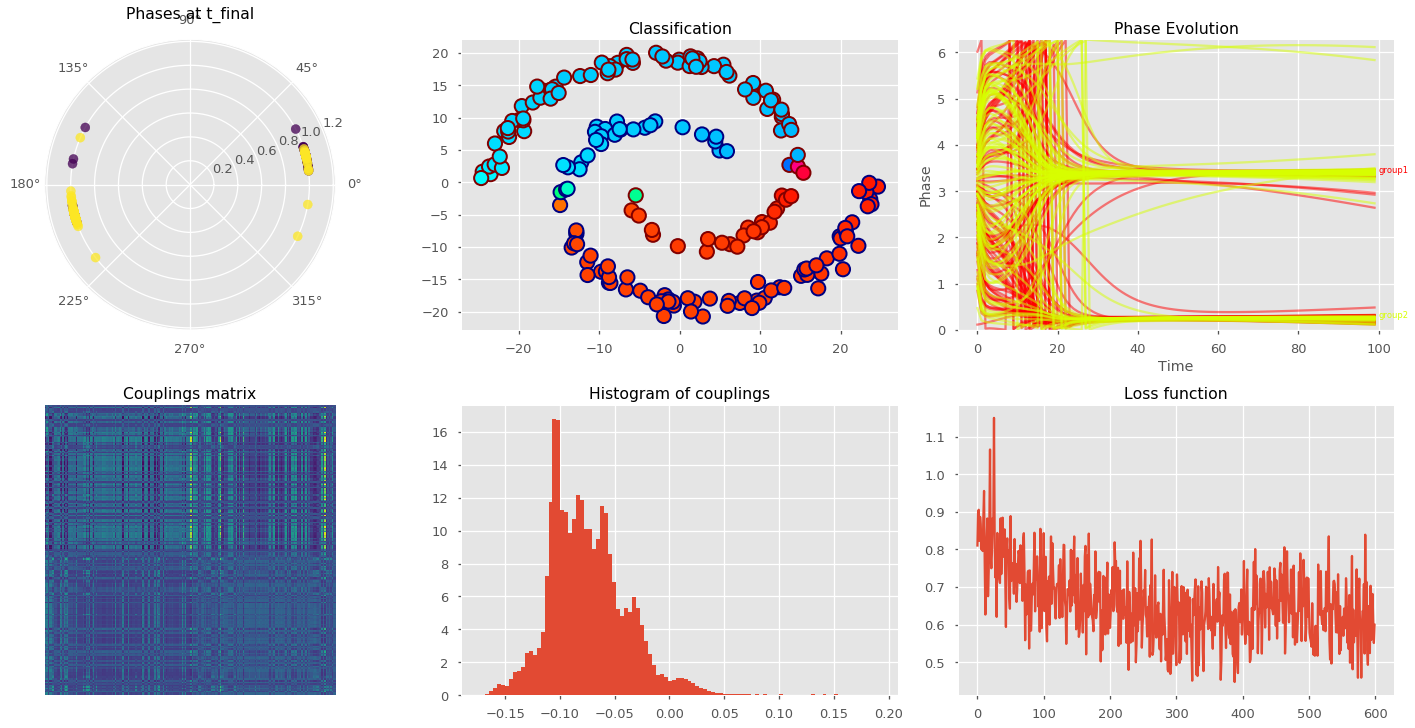

In [322]:
a = Trainer.batch
idx = Trainer.idx
sorted_idx = np.argsort(idx)
masks = torch.FloatTensor(bs,m).zero_()
masks.scatter_(1,idx.unsqueeze(1).long(),1).transpose_(1,0)
ecolors = [cm.jet(x*10) for x in idx]
# init_phase = torch.normal(np.pi,1,(bs,)).float().unsqueeze(0)
init_phase = Trainer.init
#init_phase = torch.FloatTensor(bs,).uniform_(0, 2*np.pi).unsqueeze(0)
# Trainer.init_phase(bs)
phase, couplings  = Model(Trainer.init,a)


fig = plt.figure(figsize=(20,10),constrained_layout=True)
spec4 = fig.add_gridspec(ncols=3, nrows=2)
ax = fig.add_subplot(spec4[0, 0], polar=True)
ax.set_title('Phases at t_final')
ax.scatter(phase[-1].squeeze(0).detach().numpy(), np.ones(len(idx)), c=idx, alpha=0.75)
ax = fig.add_subplot(spec4[0, 1])
ax.set_title('Classification')
ecolors = [cm.jet(x*10) for x in idx]
colors = [cm.hsv(x) for x in (phase[-1].squeeze().detach().numpy()%(2*np.pi))/(2*np.pi)]
ax.scatter(a[:,0],a[:,1],c=colors,edgecolors=ecolors,linewidth=2,s=200)
ax = fig.add_subplot(spec4[1,0])
ax.set_title('Couplings matrix')
sorted_couplings = couplings[sorted_idx,:]
sorted_couplings = sorted_couplings[:,sorted_idx].detach().numpy()
ax.imshow(sorted_couplings)
#ax.colorbar()
plt.axis('off')
ax.grid(b=None)#ax.colorbar()
#ax.set_axis('off')
ax = fig.add_subplot(spec4[1,1])
ax.set_title('Histogram of couplings')
ax.hist(couplings.reshape(-1).detach().numpy(), 100, density=True)
ax = fig.add_subplot(spec4[0,2])
phase_evol_ax(ax,phase.detach(),masks.unsqueeze(0).data.numpy())
ax = fig.add_subplot(spec4[1,2])
ax.set_title('Loss function')
ax.plot(Trainer.lh)
#plt.savefig('circles classification',dpi=200)
plt.show()

### Feedback network

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
plt.style.use('ggplot')
import torch
from torch.nn.functional import softmax
from scipy.special import softmax as np_softmax
from scipy.linalg import toeplitz, circulant
import numpy as np
from torch.autograd import Variable
from torch.distributions import uniform, cauchy, normal, relaxed_bernoulli
import matplotlib.animation as animation
from IPython.display import HTML
import time
import ipdb

In [7]:
def update_gif(i, im, data):
    im.set_array(data[i])
    return im

def show_connectivities_gif(connectivities):
    im = plt.imshow(connectivities[0], animated=True)
    ani = animation.FuncAnimation(fig, update_gif, fargs=(im, connectivities))
    plt.show(block=False)

In [8]:
def sigmoid(x):
    return 1. / (1 + torch.exp(-1*(x)))

def normalize(x):
    return x / torch.sqrt((x**2).sum())

In [9]:
def make_connectivity(soft_connectivity):
    batch_size = soft_connectivity.shape[0]
    ut_size = soft_connectivity.shape[-1]
    num_units = int(.5*(np.sqrt(8*ut_size + 1) + 1))
    triu_ind = torch.triu_indices(row=num_units, col=num_units, offset=1)

    connectivity = torch.zeros((batch_size, num_units, num_units))
    _, hard_inds = torch.topk(soft_connectivity,num_links, dim=-1)
    hard_connectivity = torch.zeros_like(soft_connectivity).scatter_(1,hard_inds, torch.ones_like(hard_inds).float())
    ut_connectivity = hard_connectivity - soft_connectivity.detach() + soft_connectivity

    connectivity[:,triu_ind[0],triu_ind[1]] = ut_connectivity
    connectivity += connectivity.transpose(2,1)
    return connectivity

In [10]:
def get_dist(dist_name,):
    if dist_name == 'cauchy':
        loc = 0.0
        scale = 1.0
        dist = cauchy.Cauchy(loc, scale)
        g0 = torch.exp(dist.log_prob(loc))
        return dist, g0
    elif dist_name == 'uniform':
        high = 1.0
        low = -1.0
        g0 = 1. / (high - low)
        dist = uniform.Uniform(-1.0, 1.0)
        return dist, g0

In [11]:
def get_current_lr(optimizer):
    # Adam has different learning rates for each paramter. So we need to pick the
    # group and paramter first.
    lrs = []
    for group in optimizer.param_groups:
        for p in group['params']:
            beta1, _ = group['betas']
            state = optimizer.state[p]

            bias_correction1 = 1 - beta1 ** state['step']
            lrs.append(group['lr'] / bias_correction1)
    return lrs

In [12]:
# Loss functions and statistics

def circular_variance(phases):
    num_phases = phases.shape[-1]
    xx = torch.cos(phases)
    yy = torch.sin(phases)
    return (1 - (torch.sqrt(xx.sum(-1)**2 + yy.sum(-1)**2)) / num_phases).mean()

def c_omega(omega, connectivity):
    omega_bar = omega.mean(1).unsqueeze(1)
    num = (connectivity * torch.einsum('bi,bj->bij',(omega - omega_bar) ,(omega - omega_bar) )).sum((1,2))
    den = (connectivity * (omega - omega_bar).unsqueeze(1)**2).sum((1,2))
    return (num / den + 1e-6).mean()

def laplacian(connectivity,sym_norm=True):
    A = connectivity
    D = torch.diag_embed(A.sum(1))
    D_mask = torch.diag_embed(torch.ones_like(A.sum(1)))
    L = D-A
    D2neg = torch.where(D_mask.bool(), D**(-.5),torch.zeros_like(D))
    D2 = torch.where(D_mask.bool(), D**(.5),torch.zeros_like(D))
    D2neg = torch.where(torch.isinf(D2neg), torch.zeros_like(D2neg),D2neg)
    if sym_norm:
        return torch.bmm(D2neg,torch.bmm(L,D2))
    else:
        return L

def p_neg(omega, connectivity):
    num_units = omega.shape[1]
#     num_ut = int(num_units * (num_units - 1) / 2)
    sign_omega = torch.sign(omega)
    sign_prods = torch.einsum('bi,bj->bij',sign_omega, sign_omega)
    num_links= (connectivity > 0).sum((1,2))
    opp_connections = (sign_prods * connectivity) < 0
    return ((opp_connections.sum((1,2))) / num_links.float()).mean()

def omega_energy(omega, connectivity):
    L = laplacian(connectivity)
    return -1*torch.einsum('bi,bi->b', omega, torch.einsum('bij,bi->bj',L, omega)).mean()

In [18]:
def run_kuramoto(coupling, omega, alpha=.1, steps=100, phase_init=None, burn_in_prop=.5):
    num_units = coupling.shape[2]
    burn_in_steps = int(burn_in_prop * steps)
    
    if phase_init == None:
        phase = np.pi*torch.ones((1,num_units))
    else:
        phase = phase_init
    flow = []
    for i in range(steps):
        phase = kuramoto_step(phase,coupling,omega,alpha=alpha)
        flow.append(phase)
    flow = torch.stack(flow).transpose(1,0)
    truncated_flow = flow[:,burn_in_steps:,:]
    cv = circular_variance(truncated_flow).detach().numpy()
    return cv, flow.detach().numpy()

def kuramoto_step(phase, coupling, omega, alpha=.01):
    phase_diffs = torch.sin(phase.unsqueeze(-1) - phase.unsqueeze(-2))
    delta = alpha * (omega + (coupling * phase_diffs).sum(1))
    return phase + delta

def kuramoto_step_(phase, coupling, omega, alpha=.5):
    phase = phase.reshape(coupling.shape[0],-1).float()
    n = coupling.shape[0]
    delta_phase = (coupling.unsqueeze(0)@torch.sin(phase).float() * torch.cos(phase) - 
    coupling.unsqueeze(0)@torch.cos(phase).float() * torch.sin(phase)) / n 
    return phase + alpha*delta_phase

In [19]:
class connectivity_net(torch.nn.Module):
    def __init__(self, num_in, num_out, num_hid_units=256, num_hid_layers=1,transform=None,gain=1.):
        super(connectivity_net, self).__init__()
        self.transform=transform
        self.num_out = num_out
        self.gain = gain
        self.layers = torch.nn.ModuleList([torch.nn.Linear(num_in, num_hid_units),
                         torch.nn.ReLU()])
        for _ in range(num_hid_layers):
            self.layers.extend([torch.nn.Linear(num_hid_units, num_hid_units),torch.nn.ReLU()])
        self.layers.append(torch.nn.Linear(num_hid_units,self.num_out))
        
        for layer in self.layers:
            try :
                #torch.nn.init.orthogonal_(layer.weight, gain=1)
                #torch.nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='tanh')
                torch.nn.init.xavier_normal_(layer.weight, gain=self.gain)
                #torch.nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='tanh')
            except:
                pass
            
    def forward(self,x):   
        for layer in self.layers:
            x = layer(x)
        if self.transform == 'softmax':
            x = softmax(x,dim=-1)
        elif self.transform == 'sigmoid':
            x = sigmoid(x)  
        elif self.transform == 'Tanh':
            x = torch.tanh(x)
        #else:
        #    x = x/torch.pow(x,2).sum(-1).unsqueeze(1)
        return x

In [20]:
class KuraTrainerfeedback(object):
    
    def __init__(self, model, data_generator, LossFunc, num_out,
                          transform=None,kuramoto_steps=100, lr=.01, alpha=.1,
                          hidden_size =128, num_hid_layers=1,batch_size=256,optimizer='Adam',init_std=0.5,
                          view_connectivities=-1, feedback='full', verbose=1):
        
        super(KuraTrainerfeedback, self).__init__()
        self.data_generator = data_generator
        self.batch_size = batch_size
        self.LossFunc = LossFunc
        self.model = model
        self.verbose = verbose
        self.in_size = 100
        self.hidden_size = hidden_size 
        self.num_layers = num_hid_layers
        self.num_out = self.batch_size * self.batch_size
        self.transform=None
        self.kuramoto_steps=kuramoto_steps
        self.lr=lr
        self.alpha= alpha
        self.num_hid_layers=1,
        self.init_std = init_std
        
        self.GRU = (type(model) == KuraGRU)
        self.feedback = feedback

        #model and optimizer
        self.model = model
        if optimizer=='Adam':
            self.opt = torch.optim.Adam(self.model.parameters(), lr=lr)
        elif optimizer=='SGD':
            self.opt = torch.optim.SGD(self.model.parameters(), lr=lr)
                
    def init_phase(self,batch_size):
        self.init = torch.normal(np.pi,self.init_std,(batch_size,)).float().unsqueeze(0)
        return self.init
     
    def kuramoto_step(self, phase, coupling, omega):
        phase_diffs = torch.sin(phase.unsqueeze(-1) - phase.unsqueeze(-2))
        delta = self.alpha * (omega + (coupling * phase_diffs).sum(1))
        return phase + delta
                
    def train(self,gradient_steps=50, lr=0.1, normalized=False, eps=1e-12, num_loss=0, burn_in_prop=.5, omega_bool=False):
        
            self.losses = []
            self.init_phase(self.batch_size)
            
            with torch.no_grad():
                batch, idx = self.data_generator.sample(self.batch_size)
                self.batch = batch.float()
                self.idx = idx.float()
                self.masks = torch.FloatTensor(self.batch_size,self.data_generator.n_components).zero_()
                self.masks.scatter_(1,idx.unsqueeze(1),1).transpose_(1,0)
                if omega_bool == False:
                    omega = torch.zeros((self.batch_size,)).float()
                else:
                    omega = torch.FloatTensor((self.batch_size,)).uniform_(0,1)
            
            for i in range(gradient_steps):
                
                start = time.time()
                self.phase_trajectory = []
                self.couplings = []
                    
                #Initial parameters
                self.init_phase(self.batch_size)
                phase = self.init
                self.phase_trajectory.append(phase)
                
                if self.feedback == 'full':
                    for j in range(self.kuramoto_steps):
                    #for j in range(np.random.randint(low=50, high=150)):

                        #Update functions
                        #x_in = torch.cat([self.batch.reshape(1,-1),phase],1)
                        out = self.model(phase).reshape(1,self.batch_size,self.batch_size)
                        phase = self.kuramoto_step(phase, out, omega)
                        #Bookkeeping
                        self.phase_trajectory.append(phase)      
                        self.couplings.append(out) 
                elif self.feedback in ['perturbation',False]:
                    out = self.model(phase).reshape(1,self.batch_size,self.batch_size)
                    for j in range(self.kuramoto_steps):
                        phase = self.kuramoto_step(phase, out, omega)
                        #Bookkeeping
                        self.phase_trajectory.append(phase)      
                        self.couplings.append(out) 
                    
                flow = torch.stack(self.couplings).detach()
                phases = torch.stack(self.phase_trajectory)
                
                #Loss computation
                loss = self.LossFunc(phases,self.masks,split=True, burn_in_prop=burn_in_prop)
                loss[num_loss].backward()
                self.phases = phases.detach()
                self.losses.append(loss[num_loss].detach().cpu().numpy())
                self.opt.step()
                self.opt.zero_grad()
                stop = time.time()
                
                if self.verbose:
                    print('Iteration {}. Loss: {}. Time/flow: {}'.format(i, self.losses[-1], stop-start))

                #if cv != cv:
                #    ipdb.set_trace()

            return self.losses
        
    def run(self,kuramoto_steps=50, normalized=False,num_loss=0,burn_in_prop=.5):

        start = time.time()
        self.phase_trajectory = []
        self.couplings = []
        #with torch.no_grad():
        #    batch, idx = self.data_generator.sample(self.batch_size)
        #    self.batch = batch.float()
        #    self.idx = idx.float()
        #    self.masks = torch.FloatTensor(self.batch_size,self.data_generator.n_components).zero_()
        #    self.masks.scatter_(1,idx.unsqueeze(1),1).transpose_(1,0)

        #Initial parameters
        self.init_phase(self.batch_size)
        phase = self.init  
        omega = torch.zeros_like(phase)
        self.phase_trajectory.append(phase)

        if self.feedback == 'full':
            for j in range(kuramoto_steps):
                out = self.model(phase).reshape(1,self.batch_size,self.batch_size)
                phase = self.kuramoto_step(phase, out, omega)
                #Bookkeeping
                self.phase_trajectory.append(phase)      
                self.couplings.append(out) 
        elif self.feedback in ['perturbation',False]:
            out = self.model(phase).reshape(1,self.batch_size,self.batch_size)
            for j in range(kuramoto_steps):
                phase = self.kuramoto_step(phase, out, omega)
                #Bookkeeping
                self.phase_trajectory.append(phase)      
                self.couplings.append(out) 
            

        self.flow = torch.stack(self.couplings).detach()
        self.phases = torch.stack(self.phase_trajectory).detach()

        #Loss computation
        loss = self.LossFunc(self.phases,self.masks,split=True, burn_in_prop=burn_in_prop)
        stop = time.time()
        
        return loss
            
    def train_GRU(self,gradient_steps=50, lr=0.1, normalized=False, eps=1e-12, num_loss=0, burn_in_prop=.5, omega_bool=False):

        self.losses = []
        self.init_phase(self.batch_size)

        with torch.no_grad():
            batch, idx = self.data_generator.sample(self.batch_size)
            self.batch = batch.float()
            self.idx = idx.float()
            self.masks = torch.FloatTensor(self.batch_size,self.data_generator.n_components).zero_()
            self.masks.scatter_(1,idx.unsqueeze(1),1).transpose_(1,0)
            if omega_bool == False:
                omega = torch.zeros((self.batch_size,)).float()
            else:
                omega = torch.FloatTensor((self.batch_size,)).uniform_(0,1)


        for i in range(gradient_steps):
            
            start = time.time()
            self.phase_trajectory = []
            self.couplings = []
            self.hiddens = []

            #Initial parameters
            if self.GRU:
                h = self.model.init_hidden(self.batch_size)
                
            #Initial parameters
            self.init_phase(self.batch_size)
            phase = self.init
            self.phase_trajectory.append(phase)

            if self.feedback == 'full':
                for j in range(self.kuramoto_steps):
                    out, h = self.model(omega, h, phase)
                    out = out.reshape(1,self.batch_size,self.batch_size)
                    phase = self.kuramoto_step(phase, out, omega)
                    self.hiddens.append(h) 
                    #Bookkeeping
                    self.phase_trajectory.append(phase)      
                    self.couplings.append(out) 
            elif self.feedback in ['perturbation',False]:
                out = self.model(phase).reshape(1,self.batch_size,self.batch_size)
                for j in range(self.kuramoto_steps):
                    phase = self.kuramoto_step(phase, out, omega)
                    #Bookkeeping
                    self.phase_trajectory.append(phase)      
                    self.couplings.append(out)

            flow = torch.stack(self.couplings).detach()
            phases = torch.stack(self.phase_trajectory)
            hiddens = torch.stack(self.hiddens)

            #Loss computation
            loss = self.LossFunc(phases,self.masks,split=True, burn_in_prop=burn_in_prop)
            loss[num_loss].backward()
            self.phases = phases.detach()
            self.losses.append(loss[num_loss].detach().cpu().numpy())
            self.opt.step()
            self.opt.zero_grad()
            stop = time.time()

            if self.verbose:
                print('Iteration {}. Loss: {}. Time/flow: {}'.format(i, self.losses[-1], stop-start))

        return self.losses
    
    
    
    def run_perturbation(self,perturbations,kuramoto_steps=50,num_loss=0):

        start = time.time()
        self.phase_trajectory = []
        self.couplings = []
        #with torch.no_grad():
        #    batch, idx = self.data_generator.sample(self.batch_size)
        #    self.batch = batch.float()
        #    self.idx = idx.float()
        #    self.masks = torch.FloatTensor(self.batch_size,self.data_generator.n_components).zero_()
        #    self.masks.scatter_(1,idx.unsqueeze(1),1).transpose_(1,0)

        #Initial parameters
        self.init_phase(self.batch_size)
        phase = self.init  
        omega = torch.zeros_like(phase)
        self.phase_trajectory.append(phase)

        
        if self.feedback:
            for j in range(kuramoto_steps):
            #for j in range(np.random.randint(low=50, high=150)):
                if j in perturbations.keys():
                    with torch.no_grad():
                        phase = phase + perturbations[j]

                #Update functions
                #x_in = torch.cat([self.batch.reshape(1,-1),phase],1)
                out = self.model(phase).reshape(1,self.batch_size,self.batch_size)
                phase = self.kuramoto_step(phase, out, omega)
                #Bookkeeping
                self.phase_trajectory.append(phase)      
                self.couplings.append(out) 
        elif self.feedback == 'perturbation':
            out = self.model(phase).reshape(1,self.batch_size,self.batch_size)
            for j in range(kuramoto_steps):
                if j in perturbations.keys():
                    with torch.no_grad():
                        phase = phase + perturbations[j]
                    out = self.model(phase).reshape(1,self.batch_size,self.batch_size)
                        
                phase = self.kuramoto_step(phase, out, omega)
                #Bookkeeping
                self.phase_trajectory.append(phase)      
                self.couplings.append(out) 
        elif self.feedback == False:
            out = self.model(phase).reshape(1,self.batch_size,self.batch_size)
            for j in range(kuramoto_steps):
                if j in perturbations.keys():
                    with torch.no_grad():
                        phase = phase + perturbations[j]
                        
                phase = self.kuramoto_step(phase, out, omega)
                #Bookkeeping
                self.phase_trajectory.append(phase)      
                self.couplings.append(out) 


        self.flow = torch.stack(self.couplings).detach()
        self.phases = torch.stack(self.phase_trajectory).detach()

        #Loss computation
        loss = self.LossFunc(self.phases,self.masks,split=True, burn_in_prop=.19)
        stop = time.time()
        

        return loss

# More oscillators n = 200, fixed init, fixed time

In [23]:
#### Linear modeling

# Training parameters
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
batch_size=50
transform='softmax'
num_hid_units= 200
num_hid_layers = 1
kuramoto_steps= 100
alpha = 0.1
burn_in_steps = 75
lr=1e-4
optimizer='Adam'




num_in = batch_size #+ 2*batch_size
hidden_size = 100
num_out = batch_size*batch_size

model = connectivity_net(num_in, num_out, num_hid_units=num_hid_units, num_hid_layers=1,transform=None)
data_generator = GMM(n_components=5, centroids=[[2,-2],[4,4],[-3,3],[-2,-5],[0,10]], cov_matrices=[0.05*np.eye(2),0.02*np.diag([1,5]),0.02*np.eye(2),0.01*np.eye(2),0.01*np.eye(2)])
LossFunc = circular_moments_batch
Trainer =  KuraTrainerfeedback(model, 
                          data_generator, 
                          LossFunc,
                          num_out,  
                          batch_size=batch_size,
                          transform=transform,
                          alpha=alpha,
                          lr=lr,
                          kuramoto_steps=kuramoto_steps,
                          num_hid_layers=num_hid_layers,
                          optimizer=optimizer,
                          verbose=1)

losses = Trainer.train(gradient_steps = 500,num_loss=0, burn_in_prop=.20)

Iteration 0. Loss: 1.3345144987106323. Time/flow: 0.5111241340637207
Iteration 1. Loss: 1.2206629514694214. Time/flow: 0.4990513324737549
Iteration 2. Loss: 1.2441271543502808. Time/flow: 0.551288366317749
Iteration 3. Loss: 1.4810750484466553. Time/flow: 0.44463467597961426
Iteration 4. Loss: 1.8118611574172974. Time/flow: 0.5914106369018555
Iteration 5. Loss: 1.1321192979812622. Time/flow: 0.4084205627441406
Iteration 6. Loss: 1.4659051895141602. Time/flow: 0.3548750877380371
Iteration 7. Loss: 1.6341627836227417. Time/flow: 0.35892248153686523
Iteration 8. Loss: 1.4006487131118774. Time/flow: 0.4834024906158447
Iteration 9. Loss: 1.4851961135864258. Time/flow: 0.5142402648925781
Iteration 10. Loss: 1.509296178817749. Time/flow: 0.4470372200012207
Iteration 11. Loss: 1.2409764528274536. Time/flow: 0.5663220882415771
Iteration 12. Loss: 1.6491672992706299. Time/flow: 0.4819808006286621
Iteration 13. Loss: 1.4220356941223145. Time/flow: 0.5298585891723633
Iteration 14. Loss: 0.87015467

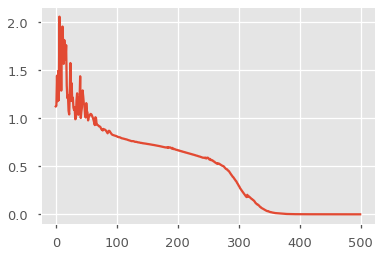

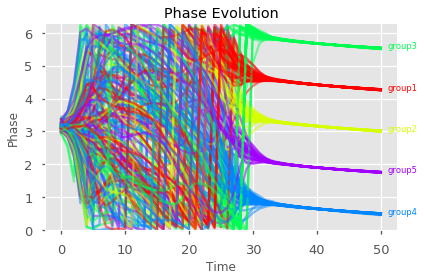

In [42]:
plt.plot(losses)
plt.show()
phase_evol(Trainer.phases,Trainer.masks.unsqueeze(0).data.numpy())

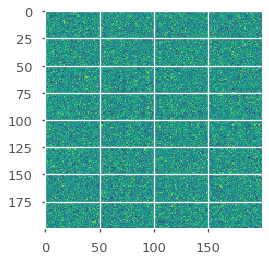

In [43]:
fig, ax = plt.subplots()
tmp_connectivities = torch.stack(Trainer.couplings)[:,0,...].detach().numpy()
im = plt.imshow(tmp_connectivities[0,...])
animate = lambda i: im.set_array(tmp_connectivities[i,...])
ani = animation.FuncAnimation(fig, animate, frames=kuramoto_steps)
HTML(ani.to_html5_video())

# GRU model

In [16]:
class KuraGRU(torch.nn.Module):
    def __init__(self, num_in, num_out, hidden_size, num_hid_units=256, num_layers=1, transform=None):
        super(KuraGRU, self).__init__()
        
        self.num_in=num_in
        self.num_out = num_out
        self.num_hid_units = num_hid_units
        self.num_layers = num_layers
        self.transform = transform
        
        #Model instanciation
        gru_in = self.num_in
        self.gru = torch.nn.GRU(gru_in, num_hid_units, num_layers)
        self.fc = torch.nn.Linear(self.num_hid_units, self.num_out)
        self.relu = torch.nn.ReLU()
        
                
    def forward(self, omega, h, phase, alpha=1e-1, GRU_steps=10, kuramoto_steps=100):
     
        #data = torch.cat([omega, phase], dim=-1).unsqueeze(0)
        out, h = self.gru(phase.unsqueeze(0),h)
        out = self.fc(self.relu(out.squeeze(0)))

        return out, h
        
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.num_layers, 1, self.num_hid_units).zero_()
        return hidden

In [112]:

# Training parameters
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
batch_size=50
transform='softmax'
num_hid_units= 200
num_hid_layers = 2
kuramoto_steps= 200
alpha = 0.1
lr=1e-4
optimizer='Adam'


num_in = batch_size #+ 2*batch_size
hidden_size = 50
num_out = batch_size*batch_size

model = KuraGRU(num_in, num_out, hidden_size, num_hid_units=num_hid_units, num_layers=num_hid_layers, transform=None)
data_generator = GMM(n_components=5, centroids=[[2,-2],[4,4],[-3,3],[-2,-5],[0,10]], cov_matrices=[0.05*np.eye(2),0.02*np.diag([1,5]),0.02*np.eye(2),0.01*np.eye(2),0.01*np.eye(2)])
LossFunc = circular_moments_batch
Trainer =  KuraTrainerfeedback(model, 
                          data_generator, 
                          LossFunc,
                          num_out,  
                          batch_size=batch_size,
                          transform=transform,
                          alpha=alpha,
                          lr=lr,
                          kuramoto_steps=kuramoto_steps,
                          num_hid_layers=num_hid_layers,
                          optimizer=optimizer,
                          verbose=1)

losses = Trainer.train_GRU(gradient_steps = 1000,num_loss=0, burn_in_prop=0.99, omega_bool=True)

Iteration 0. Loss: 1.1410802602767944. Time/flow: 1.1851062774658203
Iteration 1. Loss: 0.9886455535888672. Time/flow: 1.1832828521728516
Iteration 2. Loss: 1.7770967483520508. Time/flow: 1.0591325759887695
Iteration 3. Loss: 0.8390504717826843. Time/flow: 1.1357171535491943
Iteration 4. Loss: 1.137668251991272. Time/flow: 1.1479482650756836
Iteration 5. Loss: 1.1680556535720825. Time/flow: 0.9694936275482178
Iteration 6. Loss: 0.8512455821037292. Time/flow: 1.574683427810669
Iteration 7. Loss: 0.8247014880180359. Time/flow: 1.107557773590088
Iteration 8. Loss: 1.2341785430908203. Time/flow: 1.3419017791748047
Iteration 9. Loss: 1.1921195983886719. Time/flow: 1.0648598670959473
Iteration 10. Loss: 2.4963619709014893. Time/flow: 1.0877313613891602
Iteration 11. Loss: 1.7086458206176758. Time/flow: 0.8555121421813965
Iteration 12. Loss: 1.7801614999771118. Time/flow: 0.8608074188232422
Iteration 13. Loss: 1.4067796468734741. Time/flow: 1.1017169952392578
Iteration 14. Loss: 1.10760152339

In [116]:
losses = Trainer.train_GRU(gradient_steps = 2000,num_loss=0, burn_in_prop=0.99, omega_bool=True)

Iteration 0. Loss: 1.2132443189620972. Time/flow: 0.91910719871521
Iteration 1. Loss: 1.319364309310913. Time/flow: 1.139345407485962
Iteration 2. Loss: 1.2298909425735474. Time/flow: 1.0218846797943115
Iteration 3. Loss: 0.9192079901695251. Time/flow: 1.109044075012207
Iteration 4. Loss: 1.2739953994750977. Time/flow: 0.9409596920013428
Iteration 5. Loss: 1.076851487159729. Time/flow: 1.2630932331085205
Iteration 6. Loss: 0.8748417496681213. Time/flow: 1.1254310607910156
Iteration 7. Loss: 1.2084813117980957. Time/flow: 1.0290000438690186
Iteration 8. Loss: 0.9180638194084167. Time/flow: 0.9081947803497314
Iteration 9. Loss: 0.8941919803619385. Time/flow: 1.0255353450775146
Iteration 10. Loss: 1.1347020864486694. Time/flow: 1.040999174118042
Iteration 11. Loss: 1.2619493007659912. Time/flow: 1.267333745956421
Iteration 12. Loss: 1.338619589805603. Time/flow: 1.0955932140350342
Iteration 13. Loss: 0.9591608643531799. Time/flow: 1.042973279953003
Iteration 14. Loss: 0.9274352192878723. 

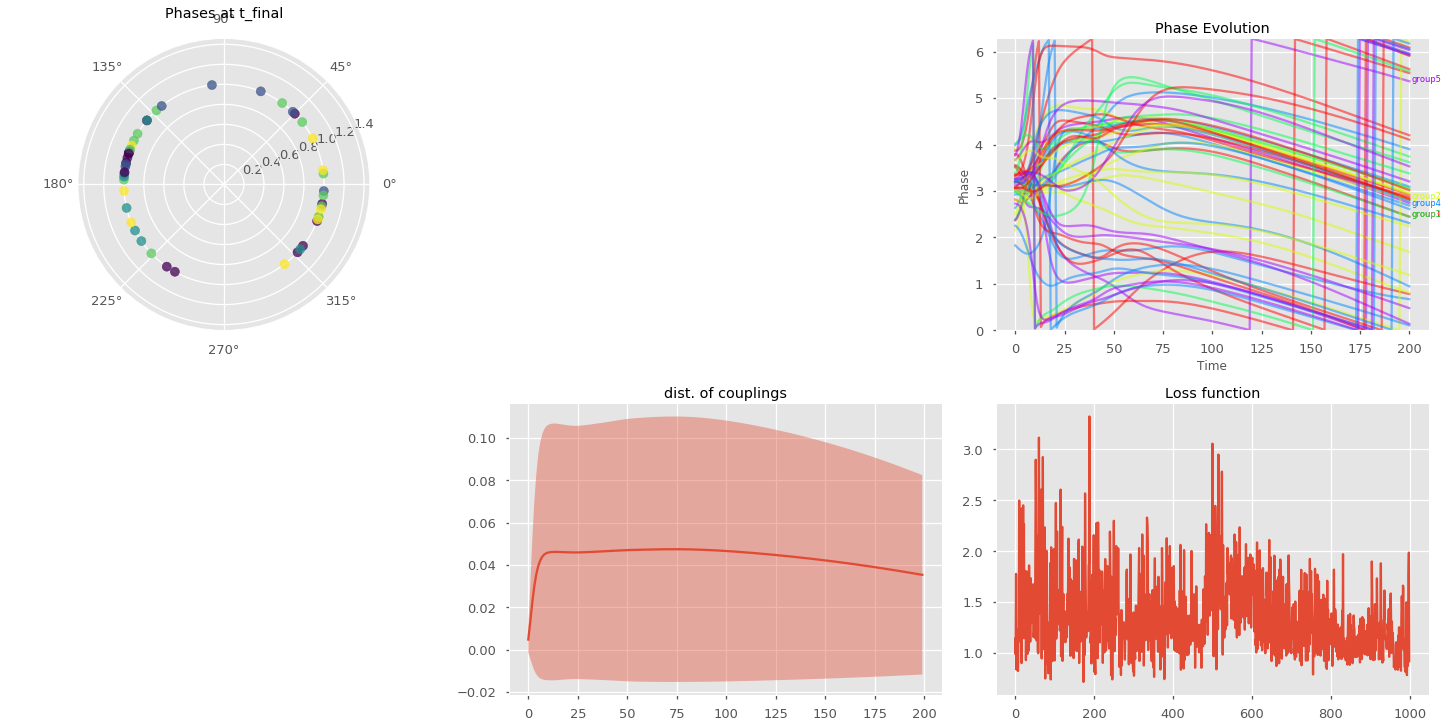

In [115]:
init_phase = Trainer.init
a = Trainer.batch
idx = Trainer.idx
phase = Trainer.phases
hiddens = Trainer.hiddens
couplings = torch.stack(Trainer.couplings).reshape(200,50,50)
masks = Trainer.masks
ecolors = [cm.jet(x*10) for x in idx]


fig = plt.figure(figsize=(20,10),constrained_layout=True)
spec4 = fig.add_gridspec(ncols=3, nrows=2)

ax = fig.add_subplot(spec4[0, 0], polar=True)
ax.set_title('Phases at t_final')
ax.scatter(phase[-1].squeeze(0).detach().numpy(), np.ones(len(idx)), c=idx, alpha=0.75)


ax = fig.add_subplot(spec4[1,1])
ax.set_title('dist. of couplings')
mean = torch.pow(couplings,2).mean((1,2)).detach().numpy()
std = torch.pow(couplings,2).std((1,2)).detach().numpy()
ax.plot(mean)
ax.fill_between(np.arange(200),mean-std,mean+std,alpha=0.4)

#ax = fig.add_subplot(spec4[1,0])
#ax.set_title('hiddens')
#ax.plot(hiddens[:,0], hiddens[:,1], hiddens[:,2])

ax = fig.add_subplot(spec4[0,2])
phase_evol_ax(ax,phase,masks.unsqueeze(0).data.numpy())

ax = fig.add_subplot(spec4[1,2])
ax.set_title('Loss function')
ax.plot(losses)
#plt.savefig('feedback control 3D',dpi=200)
plt.show()

# Fixed graph

In [15]:
# Training parameters
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
n_nodes=50
n_groups = 5
transform='softmax'
num_hid_units= 200
num_hid_layers = 2
kuramoto_steps= 200
alpha = 0.1
lr=1e-4
optimizer='Adam'
init_std = 0.5



num_in = n_nodes #+ 2*batch_size
hidden_size = 100
num_out = n_nodes*n_nodes

model = connectivity_net(num_in, num_out, num_hid_units=num_hid_units, num_hid_layers=num_hid_layers,transform=None,gain=0.5)
data_generator = fixed_graph(n_nodes, n_groups)
LossFunc = circular_moments_batch
Trainer =  KuraTrainerfeedback(model, 
                          data_generator, 
                          LossFunc,
                          num_out,  
                          batch_size=n_nodes,
                          transform=transform,
                          alpha=alpha,
                          lr=lr,
                          kuramoto_steps=kuramoto_steps,
                          num_hid_layers=num_hid_layers,
                          optimizer=optimizer,
                          verbose=1,
                          init_std=init_std)

losses = Trainer.train(gradient_steps = 1000,num_loss=0, burn_in_prop=0.99)

Iteration 0. Loss: 1.3147536516189575. Time/flow: 0.6411564350128174
Iteration 1. Loss: 1.0530158281326294. Time/flow: 0.6372945308685303
Iteration 2. Loss: 1.7355809211730957. Time/flow: 0.597893476486206
Iteration 3. Loss: 0.9957234263420105. Time/flow: 0.5526154041290283
Iteration 4. Loss: 1.5990567207336426. Time/flow: 0.5654752254486084
Iteration 5. Loss: 1.0867094993591309. Time/flow: 0.5769221782684326
Iteration 6. Loss: 0.829071044921875. Time/flow: 0.5433568954467773
Iteration 7. Loss: 1.6035822629928589. Time/flow: 0.5410676002502441
Iteration 8. Loss: 0.9301647543907166. Time/flow: 0.6111946105957031
Iteration 9. Loss: 0.8931694030761719. Time/flow: 0.5799157619476318
Iteration 10. Loss: 1.175704002380371. Time/flow: 0.5798072814941406
Iteration 11. Loss: 1.0847762823104858. Time/flow: 0.6039600372314453
Iteration 12. Loss: 1.1294336318969727. Time/flow: 0.6086776256561279
Iteration 13. Loss: 1.0507793426513672. Time/flow: 0.5706841945648193
Iteration 14. Loss: 1.40719652175

KeyboardInterrupt: 

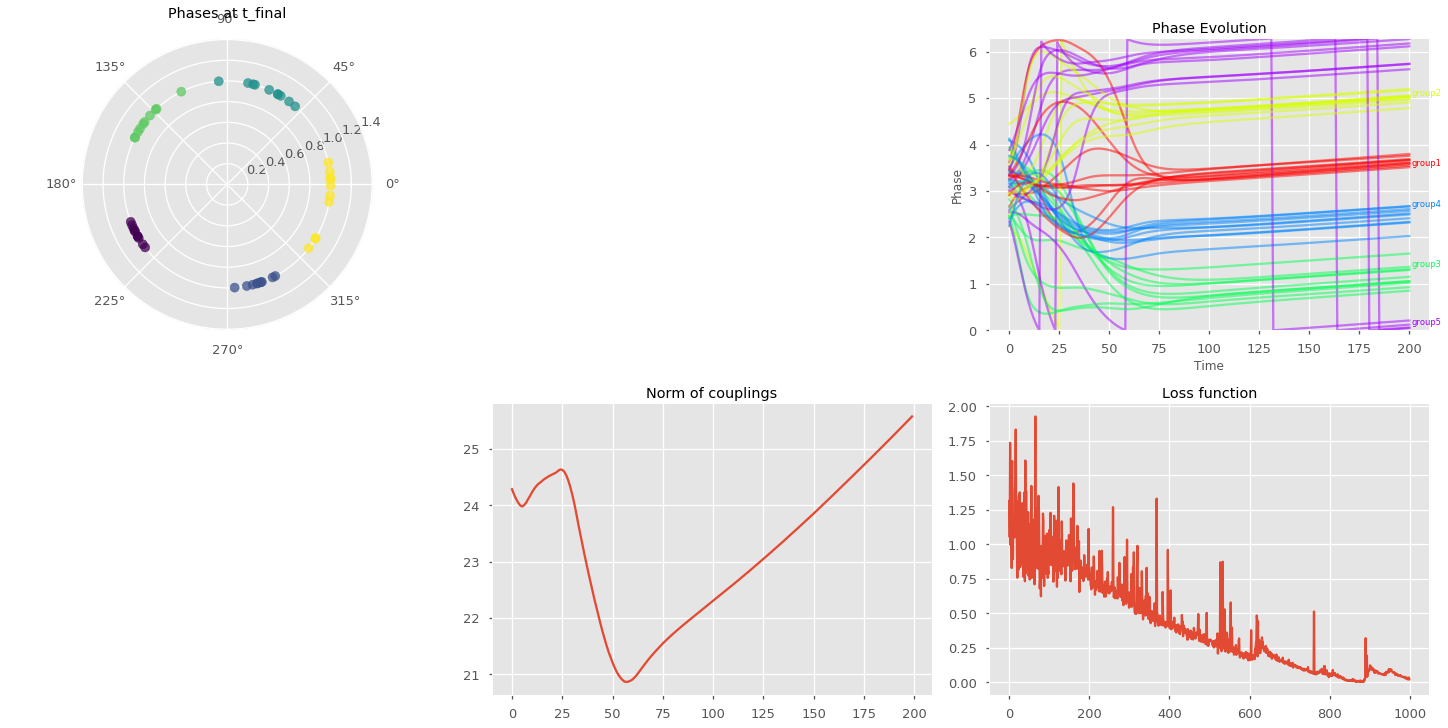

In [19]:
init_phase = Trainer.init
a = Trainer.batch
idx = Trainer.idx
phase = Trainer.phases
couplings = torch.stack(Trainer.couplings).reshape(200,50,50)
masks = Trainer.masks
ecolors = [cm.jet(x*10) for x in idx]

fig = plt.figure(figsize=(20,10),constrained_layout=True)
spec4 = fig.add_gridspec(ncols=3, nrows=2)
ax = fig.add_subplot(spec4[0, 0], polar=True)
ax.set_title('Phases at t_final')
ax.scatter(phase[-1].squeeze(0).detach().numpy(), np.ones(len(idx)), c=idx, alpha=0.75)
#ax = fig.add_subplot(spec4[0, 1])
#ax.set_title('Classification')
#ecolors = [cm.jet(x*10) for x in idx]
#colors = [cm.hsv(x) for x in (phase[-1].squeeze().detach().numpy()%(2*np.pi))/(2*np.pi)]
#ax.scatter(a[:,0],a[:,1],c=colors,edgecolors=ecolors,linewidth=2,s=200)
#ax = fig.add_subplot(spec4[1,0])
#ax.set_title('Couplings matrix')
#ax.imshow(couplings.detach().numpy())
#ax.colorbar()
#ax.set_axis('off')
ax = fig.add_subplot(spec4[1,1])
ax.set_title('Norm of couplings')
ax.plot(torch.pow(couplings,2).sum((1,2)).detach().numpy())
ax = fig.add_subplot(spec4[0,2])
phase_evol_ax(ax,phase.detach(),masks.unsqueeze(0).data.numpy())
ax = fig.add_subplot(spec4[1,2])
ax.set_title('Loss function')
ax.plot(losses)
plt.savefig('circles classification',dpi=200)
plt.show()

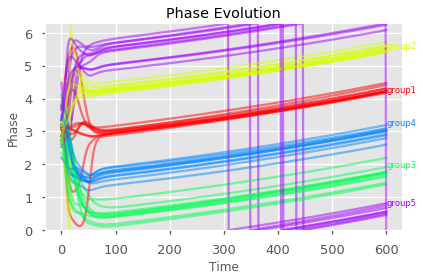

In [26]:
phase_evol(Trainer.phases,Trainer.masks.unsqueeze(0).data.numpy())

In [31]:
#Trainer.init_std = 3
perturbation = dict(zip([500,1000,1500],[torch.normal(0,1,(50,)).float().unsqueeze(0),torch.normal(0,1,(50,)).float().unsqueeze(0),torch.normal(0,1,(50,)).float().unsqueeze(0)]))
#perturbation = zip([(150,400),(torch.normal(np.pi,1,(batch_size,)).float().unsqueeze(0),torch.normal(np.pi,1,(batch_size,)).float().unsqueeze(0))])
Trainer.run_perturbation(perturbations=perturbation,kuramoto_steps=2000)

[array(1.3147537, dtype=float32),
 array(1.0530158, dtype=float32),
 array(1.7355809, dtype=float32),
 array(0.9957234, dtype=float32),
 array(1.5990567, dtype=float32),
 array(1.0867095, dtype=float32),
 array(0.82907104, dtype=float32),
 array(1.6035823, dtype=float32),
 array(0.93016475, dtype=float32),
 array(0.8931694, dtype=float32),
 array(1.175704, dtype=float32),
 array(1.0847763, dtype=float32),
 array(1.1294336, dtype=float32),
 array(1.0507793, dtype=float32),
 array(1.4071965, dtype=float32),
 array(1.4264121, dtype=float32),
 array(1.8317089, dtype=float32),
 array(1.2126554, dtype=float32),
 array(1.3141396, dtype=float32),
 array(0.9586509, dtype=float32),
 array(0.7589889, dtype=float32),
 array(1.2332859, dtype=float32),
 array(0.9858107, dtype=float32),
 array(0.8173668, dtype=float32),
 array(1.3521175, dtype=float32),
 array(1.2446847, dtype=float32),
 array(1.3767008, dtype=float32),
 array(0.8357236, dtype=float32),
 array(0.8531373, dtype=float32),
 array(0.9667

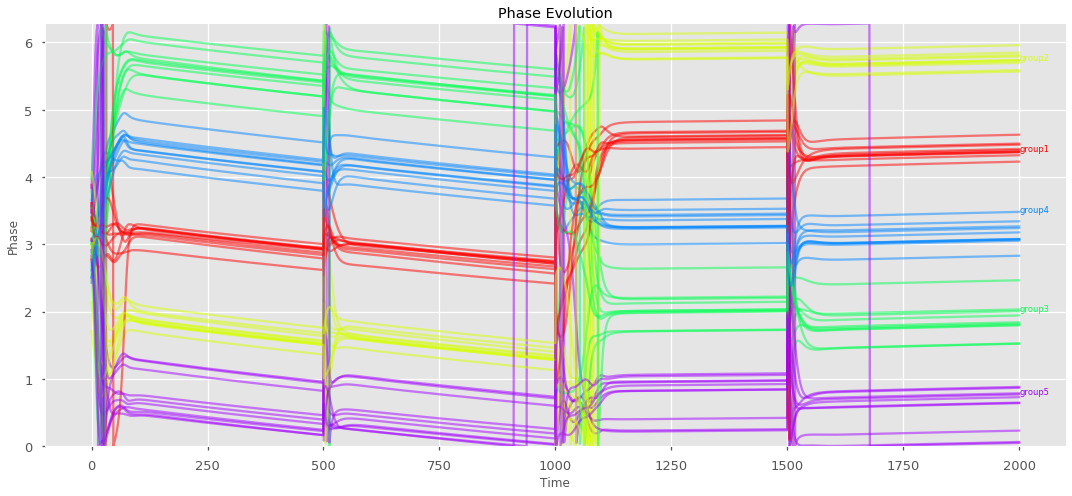

<Figure size 432x288 with 0 Axes>

In [36]:
plt.figure(figsize=(15,7))
phase_evol(Trainer.phases,Trainer.masks.unsqueeze(0).data.numpy())

## Omega uniform

In [40]:
# Training parameters
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
n_nodes=50
n_groups = 5
transform='softmax'
num_hid_units= 200
num_hid_layers = 2
kuramoto_steps= 200
alpha = 0.1
lr=1e-4
optimizer='Adam'
init_std = 0.5



num_in = n_nodes #+ 2*batch_size
hidden_size = 100
num_out = n_nodes*n_nodes

model = connectivity_net(num_in, num_out, num_hid_units=num_hid_units, num_hid_layers=num_hid_layers,transform=None,gain=0.5)
data_generator = fixed_graph(n_nodes, n_groups)
LossFunc = circular_moments_batch
Trainer =  KuraTrainerfeedback(model, 
                          data_generator, 
                          LossFunc,
                          num_out,  
                          batch_size=n_nodes,
                          transform=transform,
                          alpha=alpha,
                          lr=lr,
                          kuramoto_steps=kuramoto_steps,
                          num_hid_layers=num_hid_layers,
                          optimizer=optimizer,
                          verbose=1,
                          init_std=init_std,
                          feedback='full')

losses = Trainer.train(gradient_steps = 5000,num_loss=0, burn_in_prop=0.99,omega_bool=True)

Iteration 0. Loss: 1.2852689027786255. Time/flow: 0.5977230072021484
Iteration 1. Loss: 1.4498370885849. Time/flow: 0.607036828994751
Iteration 2. Loss: 1.4375025033950806. Time/flow: 0.6660943031311035
Iteration 3. Loss: 1.9147504568099976. Time/flow: 0.7037866115570068
Iteration 4. Loss: 1.0569055080413818. Time/flow: 0.427950382232666
Iteration 5. Loss: 1.3578068017959595. Time/flow: 0.6693646907806396
Iteration 6. Loss: 1.636955738067627. Time/flow: 0.6879527568817139
Iteration 7. Loss: 0.9945184588432312. Time/flow: 0.5581231117248535
Iteration 8. Loss: 0.8059760928153992. Time/flow: 0.6050643920898438
Iteration 9. Loss: 1.181376338005066. Time/flow: 0.6399135589599609
Iteration 10. Loss: 1.1245174407958984. Time/flow: 0.5929355621337891
Iteration 11. Loss: 1.1610075235366821. Time/flow: 0.6696281433105469
Iteration 12. Loss: 0.8650774955749512. Time/flow: 0.8428859710693359
Iteration 13. Loss: 1.2231930494308472. Time/flow: 0.5716660022735596
Iteration 14. Loss: 0.942492187023162

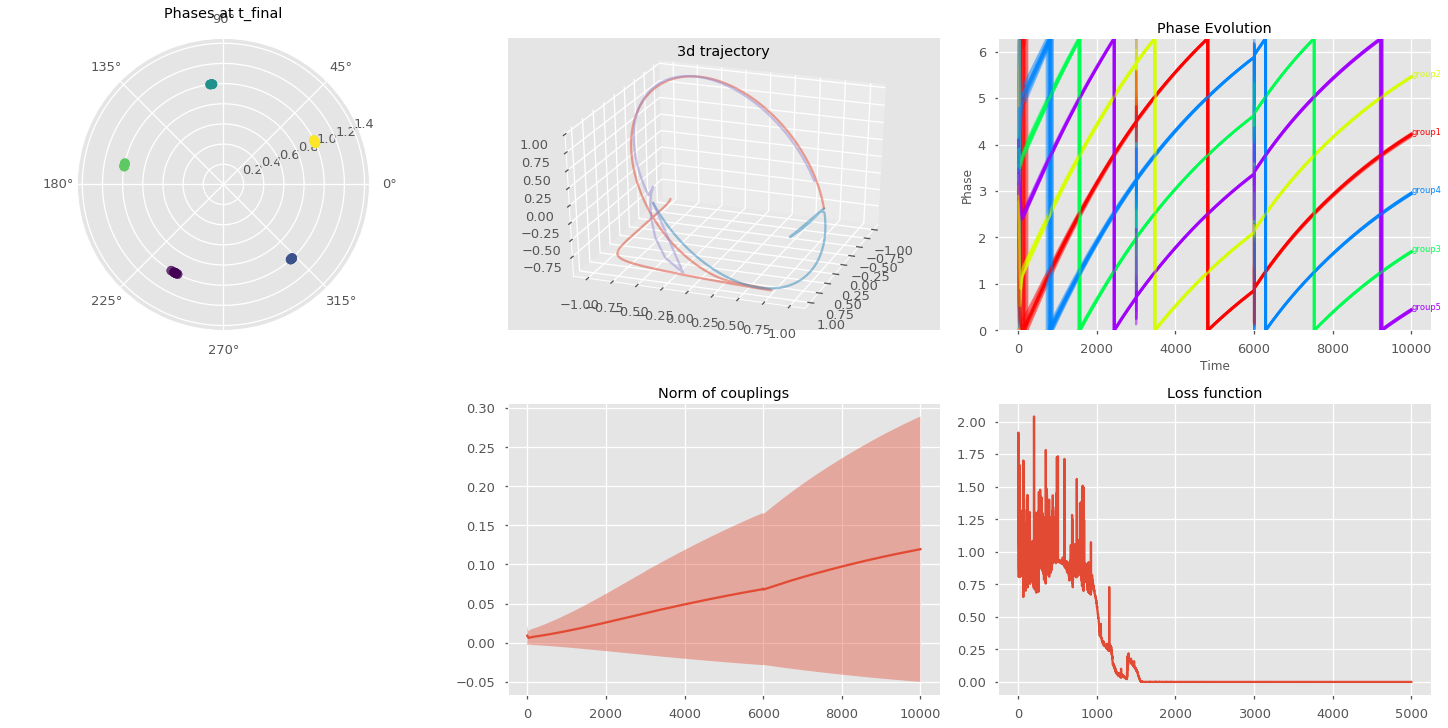

In [45]:
init_phase = Trainer.init_phase(Trainer.batch_size)
a = Trainer.batch
idx = Trainer.idx
perturbation = dict(zip([],[]))
perturbation = dict(zip([3000,6000],[torch.normal(0,1,(n_nodes,)).float().unsqueeze(0) for i in range(2)]))
Trainer.run_perturbation(perturbations=perturbation,kuramoto_steps=10000)
phase = Trainer.phases
phase1 = Trainer.phases.squeeze(1).detach().numpy()
couplings = torch.stack(Trainer.couplings).reshape(10000,50,50)
masks = Trainer.masks
ecolors = [cm.jet(x*10) for x in idx]

fig = plt.figure(figsize=(20,10),constrained_layout=True)
spec4 = fig.add_gridspec(ncols=3, nrows=2)
ax = fig.add_subplot(spec4[0, 0], polar=True)
ax.set_title('Phases at t_final')
ax.scatter(phase[-1].squeeze(0).detach().numpy(), np.ones(len(idx)), c=idx, alpha=0.75)
ax = fig.add_subplot(spec4[0, 1], projection='3d')
ax.set_title('3d trajectory')
ax.plot(np.cos(phase1[:3000,0]), np.cos(phase1[:3000,1]), np.cos(phase1[:3000,2]),alpha=0.5)
ax.plot(np.cos(phase1[3000:6000,0]), np.cos(phase1[3000:6000,1]), np.cos(phase1[3000:6000,2]),alpha=0.5)
ax.plot(np.cos(phase1[6000:,0]), np.cos(phase1[6000:,1]), np.cos(phase1[6000:,2]),alpha=0.5)
ax.view_init(elev=30, azim=20)
ax = fig.add_subplot(spec4[1,1])
ax.set_title('Norm of couplings')
mean = torch.pow(couplings,2).mean((1,2)).detach().numpy()
std = torch.pow(couplings,2).std((1,2)).detach().numpy()
ax.plot(mean)
ax.fill_between(np.arange(10000),mean-std,mean+std,alpha=0.4)
ax = fig.add_subplot(spec4[0,2])
phase_evol_ax(ax,phase.detach(),masks.unsqueeze(0).data.numpy())
ax = fig.add_subplot(spec4[1,2])
ax.set_title('Loss function')
ax.plot(losses)
plt.savefig('circles classification',dpi=200)
plt.show()

## No feedback

In [19]:
# Training parameters
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
n_nodes=50
n_groups = 5
num_hid_units= 200
num_hid_layers = 2
kuramoto_steps= 200
alpha = 0.1
lr=1e-4
optimizer='Adam'
init_std = 0.5
transform= None



num_in = n_nodes #+ 2*batch_size
hidden_size = 100
num_out = n_nodes*n_nodes

model = connectivity_net(num_in, num_out, num_hid_units=num_hid_units, num_hid_layers=num_hid_layers,transform=None,gain=0.5)
data_generator = fixed_graph(n_nodes, n_groups)
LossFunc = circular_moments_batch
Trainer =  KuraTrainerfeedback(model, 
                          data_generator, 
                          LossFunc,
                          num_out,  
                          batch_size=n_nodes,
                          transform=transform,
                          alpha=alpha,
                          lr=lr,
                          kuramoto_steps=kuramoto_steps,
                          num_hid_layers=num_hid_layers,
                          optimizer=optimizer,
                          verbose=1,
                          init_std=init_std, feedback=False)

losses = Trainer.train(gradient_steps = 5000,num_loss=0, burn_in_prop=0.99, omega_bool=True)

Iteration 0. Loss: 1.2293236255645752. Time/flow: 0.18184709548950195
Iteration 1. Loss: 1.4752155542373657. Time/flow: 0.22878694534301758
Iteration 2. Loss: 0.8778632283210754. Time/flow: 0.20957398414611816
Iteration 3. Loss: 1.3245636224746704. Time/flow: 0.27188897132873535
Iteration 4. Loss: 1.244437336921692. Time/flow: 0.0994100570678711
Iteration 5. Loss: 2.8019826412200928. Time/flow: 0.08254241943359375
Iteration 6. Loss: 1.9863084554672241. Time/flow: 0.08638715744018555
Iteration 7. Loss: 0.9139950275421143. Time/flow: 0.08268976211547852
Iteration 8. Loss: 1.5654014348983765. Time/flow: 0.08204269409179688
Iteration 9. Loss: 1.5047203302383423. Time/flow: 0.0861356258392334
Iteration 10. Loss: 2.2155895233154297. Time/flow: 0.08371090888977051
Iteration 11. Loss: 1.5135961771011353. Time/flow: 0.15657544136047363
Iteration 12. Loss: 1.1968525648117065. Time/flow: 0.16575098037719727
Iteration 13. Loss: 1.2811275720596313. Time/flow: 0.16675996780395508
Iteration 14. Loss:

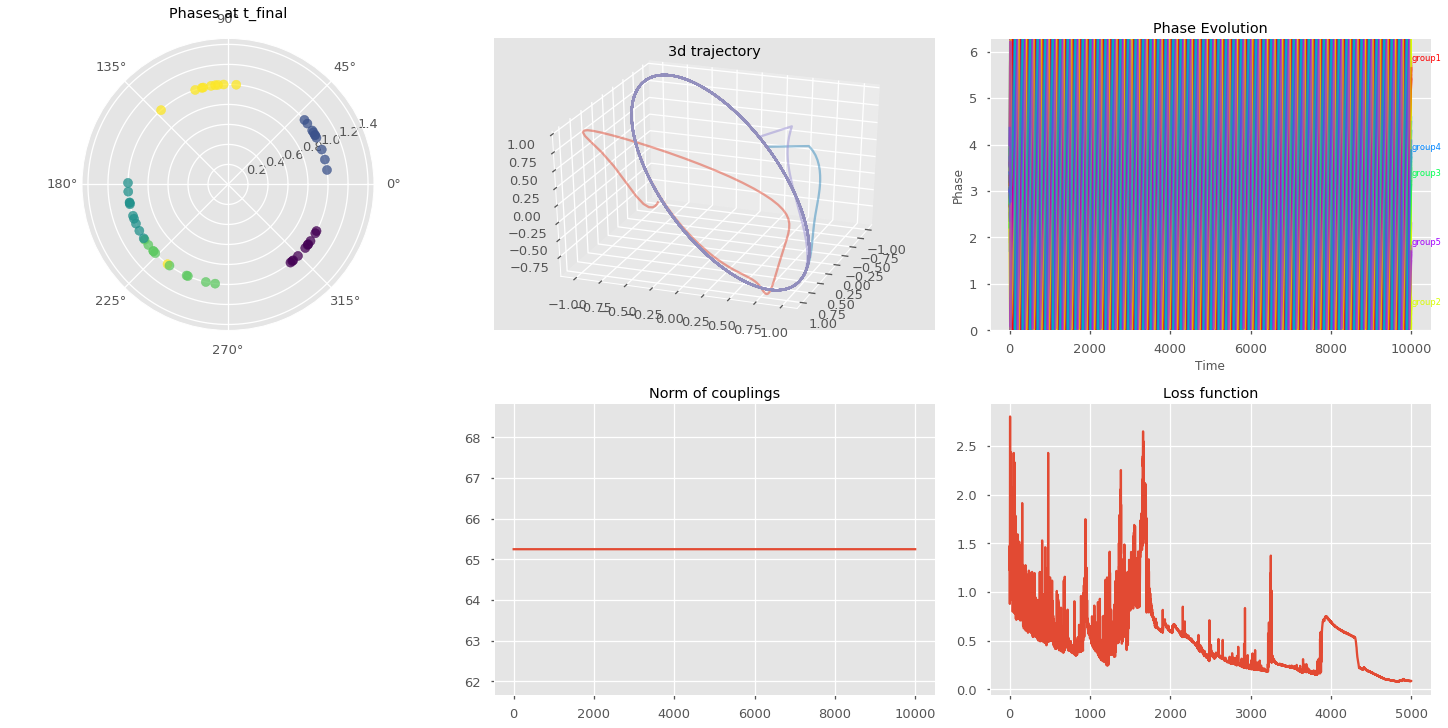

In [39]:
init_phase = Trainer.init_phase(Trainer.batch_size)
a = Trainer.batch
idx = Trainer.idx
perturbation = dict(zip([],[]))
perturbation = dict(zip([3000,6000],[torch.normal(0,0.5,(n_nodes,)).float().unsqueeze(0) for i in range(2)]))
Trainer.run_perturbation(perturbations=perturbation,kuramoto_steps=10000)
phase = Trainer.phases
phase1 = Trainer.phases.squeeze(1).detach().numpy()
couplings = torch.stack(Trainer.couplings).reshape(10000,50,50)
masks = Trainer.masks
ecolors = [cm.jet(x*10) for x in idx]

fig = plt.figure(figsize=(20,10),constrained_layout=True)
spec4 = fig.add_gridspec(ncols=3, nrows=2)
ax = fig.add_subplot(spec4[0, 0], polar=True)
ax.set_title('Phases at t_final')
ax.scatter(phase[-1].squeeze(0).detach().numpy(), np.ones(len(idx)), c=idx, alpha=0.75)
ax = fig.add_subplot(spec4[0, 1], projection='3d')
ax.set_title('3d trajectory')
ax.plot(np.cos(phase1[:3000,0]), np.cos(phase1[:3000,1]), np.cos(phase1[:3000,2]),alpha=0.5)
ax.plot(np.cos(phase1[3000:6000,0]), np.cos(phase1[3000:6000,1]), np.cos(phase1[3000:6000,2]),alpha=0.5)
ax.plot(np.cos(phase1[6000:,0]), np.cos(phase1[6000:,1]), np.cos(phase1[6000:,2]),alpha=0.5)
ax.view_init(elev=30, azim=20)
ax = fig.add_subplot(spec4[1,1])
ax.set_title('Norm of couplings')
ax.plot(torch.pow(couplings,2).sum((1,2)).detach().numpy())
ax = fig.add_subplot(spec4[0,2])
phase_evol_ax(ax,phase1,masks.unsqueeze(0).data.numpy())
ax = fig.add_subplot(spec4[1,2])
ax.set_title('Loss function')
ax.plot(losses)
#plt.savefig('feedback control 3D',dpi=200)
plt.show()

# Different groups

In [59]:
# Training parameters
seed = 4
np.random.seed(seed)
torch.manual_seed(seed)
n_nodes=50
n_groups = 10
transform=None
num_hid_units= 200
num_hid_layers = 2
kuramoto_steps= 100
alpha = 0.1
lr=1e-4
optimizer='Adam'
init_std = 1



num_in = n_nodes #+ 2*batch_size
hidden_size = 100
num_out = n_nodes*n_nodes

model = connectivity_net(num_in, num_out, num_hid_units=num_hid_units, num_hid_layers=num_hid_layers,transform=transform,gain=0.5)
data_generator = fixed_graph(n_nodes, n_groups)
LossFunc = circular_moments_batch
Trainer =  KuraTrainerfeedback(model, 
                          data_generator, 
                          LossFunc,
                          num_out,  
                          batch_size=n_nodes,
                          transform=transform,
                          alpha=alpha,
                          lr=lr,
                          kuramoto_steps=kuramoto_steps,
                          num_hid_layers=num_hid_layers,
                          optimizer=optimizer,
                          verbose=1,
                          init_std=init_std,
                          feedback='full')

losses = Trainer.train(gradient_steps = 1000,num_loss=0, burn_in_prop=0.99,omega_bool=True)

Iteration 0. Loss: 2.115884780883789. Time/flow: 0.4841644763946533
Iteration 1. Loss: 4.067736625671387. Time/flow: 0.4543468952178955
Iteration 2. Loss: 1.794327974319458. Time/flow: 0.4274277687072754
Iteration 3. Loss: 2.959616184234619. Time/flow: 0.41721534729003906
Iteration 4. Loss: 1.5442230701446533. Time/flow: 0.5311036109924316
Iteration 5. Loss: 2.1973531246185303. Time/flow: 0.4990813732147217
Iteration 6. Loss: 1.947343349456787. Time/flow: 0.48500537872314453
Iteration 7. Loss: 1.4607349634170532. Time/flow: 0.3907337188720703
Iteration 8. Loss: 1.1371862888336182. Time/flow: 0.3637230396270752
Iteration 9. Loss: 1.1206600666046143. Time/flow: 0.445878267288208
Iteration 10. Loss: 1.7669541835784912. Time/flow: 0.36530208587646484
Iteration 11. Loss: 0.6712216734886169. Time/flow: 0.5290737152099609
Iteration 12. Loss: 0.9712264537811279. Time/flow: 0.5096893310546875
Iteration 13. Loss: 1.0074808597564697. Time/flow: 0.5130255222320557
Iteration 14. Loss: 1.04096698760

In [63]:
losses = Trainer.train(gradient_steps = 1000,num_loss=0, burn_in_prop=0.99,omega_bool=True)

Iteration 0. Loss: 0.2831614017486572. Time/flow: 0.5754077434539795
Iteration 1. Loss: 0.28375697135925293. Time/flow: 0.5702908039093018
Iteration 2. Loss: 0.27270931005477905. Time/flow: 0.4005403518676758
Iteration 3. Loss: 0.26839542388916016. Time/flow: 0.44209837913513184
Iteration 4. Loss: 0.28193390369415283. Time/flow: 0.5013649463653564
Iteration 5. Loss: 0.2666330337524414. Time/flow: 0.4608156681060791
Iteration 6. Loss: 0.26731985807418823. Time/flow: 0.43370771408081055
Iteration 7. Loss: 0.265359103679657. Time/flow: 0.4898090362548828
Iteration 8. Loss: 0.2657076120376587. Time/flow: 0.5060100555419922
Iteration 9. Loss: 0.26482078433036804. Time/flow: 0.42539310455322266
Iteration 10. Loss: 0.2688644826412201. Time/flow: 0.41933369636535645
Iteration 11. Loss: 0.26384150981903076. Time/flow: 0.3981502056121826
Iteration 12. Loss: 0.259807288646698. Time/flow: 0.3754255771636963
Iteration 13. Loss: 0.25577810406684875. Time/flow: 0.4222376346588135
Iteration 14. Loss: 

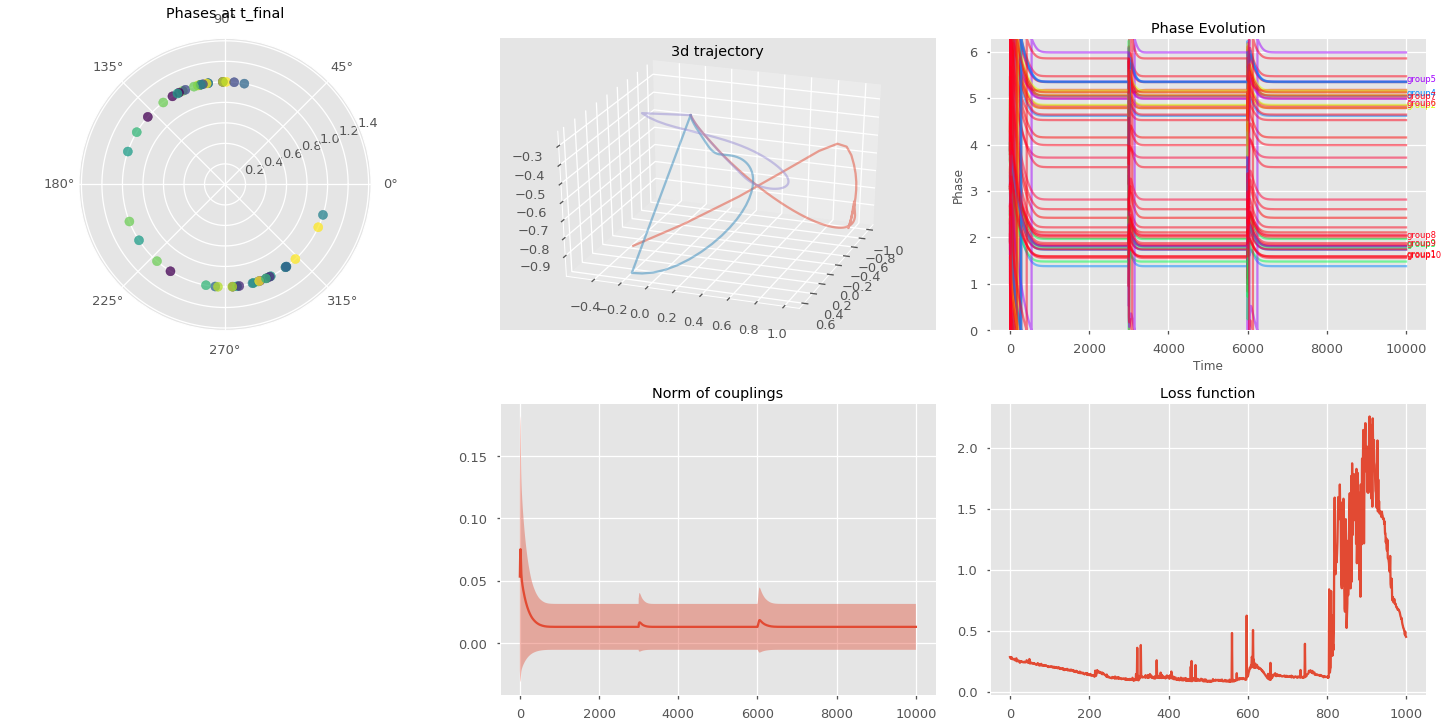

In [64]:
init_phase = Trainer.init_phase(Trainer.batch_size)
a = Trainer.batch
idx = Trainer.idx
perturbation = dict(zip([],[]))
perturbation = dict(zip([3000,6000],[torch.normal(0,1,(n_nodes,)).float().unsqueeze(0) for i in range(2)]))
Trainer.run_perturbation(perturbations=perturbation,kuramoto_steps=10000)
phase = Trainer.phases
phase1 = Trainer.phases.squeeze(1).detach().numpy()
couplings = torch.stack(Trainer.couplings).reshape(10000,50,50)
masks = Trainer.masks
ecolors = [cm.jet(x*10) for x in idx]

fig = plt.figure(figsize=(20,10),constrained_layout=True)
spec4 = fig.add_gridspec(ncols=3, nrows=2)
ax = fig.add_subplot(spec4[0, 0], polar=True)
ax.set_title('Phases at t_final')
ax.scatter(phase[-1].squeeze(0).detach().numpy(), np.ones(len(idx)), c=idx, alpha=0.75)
ax = fig.add_subplot(spec4[0, 1], projection='3d')
ax.set_title('3d trajectory')
ax.plot(np.cos(phase1[:3000,0]), np.cos(phase1[:3000,1]), np.cos(phase1[:3000,2]),alpha=0.5)
ax.plot(np.cos(phase1[3000:6000,0]), np.cos(phase1[3000:6000,1]), np.cos(phase1[3000:6000,2]),alpha=0.5)
ax.plot(np.cos(phase1[6000:,0]), np.cos(phase1[6000:,1]), np.cos(phase1[6000:,2]),alpha=0.5)
ax.view_init(elev=30, azim=20)
ax = fig.add_subplot(spec4[1,1])
ax.set_title('Norm of couplings')
mean = torch.pow(couplings,2).mean((1,2)).detach().numpy()
std = torch.pow(couplings,2).std((1,2)).detach().numpy()
ax.plot(mean)
ax.fill_between(np.arange(10000),mean-std,mean+std,alpha=0.4)
ax = fig.add_subplot(spec4[0,2])
phase_evol_ax(ax,phase.detach(),masks.unsqueeze(0).data.numpy())
ax = fig.add_subplot(spec4[1,2])
ax.set_title('Loss function')
ax.plot(losses)
plt.savefig('circles classification',dpi=200)
plt.show()

In [16]:
# Training parameters
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)
n_nodes=100
n_groups =3
num_hid_units= 200
num_hid_layers = 2
kuramoto_steps= 200
alpha = 0.1
lr=1e-4
optimizer='Adam'
init_std = 1



num_in = n_nodes #+ 2*batch_size
hidden_size = 100
num_out = n_nodes*n_nodes

model = connectivity_net(num_in, num_out, num_hid_units=num_hid_units, num_hid_layers=num_hid_layers,transform=None,gain=0.5)
data_generator = fixed_graph(n_nodes, n_groups)
LossFunc = circular_moments_batch
Trainer =  KuraTrainerfeedback(model, 
                          data_generator, 
                          LossFunc,
                          num_out,  
                          batch_size=n_nodes,
                          transform=transform,
                          alpha=alpha,
                          lr=lr,
                          kuramoto_steps=kuramoto_steps,
                          num_hid_layers=num_hid_layers,
                          optimizer=optimizer,
                          verbose=1,
                          init_std=init_std,
                          feedback='full')

losses = Trainer.train(gradient_steps = 2000,num_loss=0, burn_in_prop=0.99,omega_bool=True)

Iteration 0. Loss: 1.3155570030212402. Time/flow: 1.3793056011199951
Iteration 1. Loss: 1.286280870437622. Time/flow: 1.2154333591461182
Iteration 2. Loss: 1.4512335062026978. Time/flow: 1.09130859375
Iteration 3. Loss: 1.4895548820495605. Time/flow: 1.6686882972717285
Iteration 4. Loss: 0.966804027557373. Time/flow: 1.0956389904022217
Iteration 5. Loss: 1.216212272644043. Time/flow: 1.0309948921203613
Iteration 6. Loss: 0.9984450340270996. Time/flow: 1.0433344841003418
Iteration 7. Loss: 2.3667216300964355. Time/flow: 1.22487211227417
Iteration 8. Loss: 1.062456488609314. Time/flow: 1.0146949291229248
Iteration 9. Loss: 0.8996148109436035. Time/flow: 0.9844095706939697
Iteration 10. Loss: 1.0280464887619019. Time/flow: 1.0332176685333252
Iteration 11. Loss: 0.989069402217865. Time/flow: 1.299410343170166
Iteration 12. Loss: 2.171069383621216. Time/flow: 1.2600798606872559
Iteration 13. Loss: 1.4422483444213867. Time/flow: 1.1397778987884521
Iteration 14. Loss: 1.3576866388320923. Time

KeyboardInterrupt: 

# Frequencies optimization

In [33]:
class KuraTrainerfrequenciesfeedback(object):
    
    def __init__(self, model, data_generator, LossFunc, num_out,
                          transform=None,kuramoto_steps=100, lr=.01, alpha=.1,
                          hidden_size =128, num_hid_layers=1,batch_size=256,optimizer='Adam',init_std=0.5,
                          view_connectivities=-1, feedback='full', verbose=1):
        
        super(KuraTrainerfrequenciesfeedback, self).__init__()
        self.data_generator = data_generator
        self.batch_size = batch_size
        self.LossFunc = LossFunc
        self.model = model
        self.verbose = verbose
        self.in_size = 100
        self.hidden_size = hidden_size 
        self.num_layers = num_hid_layers
        self.num_out = self.batch_size
        self.transform=None
        self.kuramoto_steps=kuramoto_steps
        self.lr=lr
        self.alpha= alpha
        self.num_hid_layers=1,
        self.init_std = init_std
        
        self.GRU = (type(model) == KuraGRU)
        self.feedback = feedback

        #model and optimizer
        self.model = model
        if optimizer=='Adam':
            self.opt = torch.optim.Adam(self.model.parameters(), lr=lr)
        elif optimizer=='SGD':
            self.opt = torch.optim.SGD(self.model.parameters(), lr=lr)
                
    def init_couplings(self,batch_size):
        self.couplings = torch.normal(0,self.init_std,(batch_size,batch_size,)).float().unsqueeze(0)
        return self.couplings
    
    def init_phase(self,batch_size):
        self.phase = torch.normal(np.pi,self.init_std,(batch_size,)).float().unsqueeze(0)
        return self.phase
     
    def kuramoto_step(self, phase, coupling, omega):
        phase_diffs = torch.sin(phase.unsqueeze(-1) - phase.unsqueeze(-2))
        delta = self.alpha * (omega + (coupling * phase_diffs).sum(1))
        return phase + delta
                
    def train(self,gradient_steps=50, lr=0.1, normalized=False, eps=1e-12, num_loss=0, burn_in_prop=.5, omega_bool=False):
        
            self.losses = []
            
            with torch.no_grad():
                batch, idx = self.data_generator.sample(self.batch_size)
                self.batch = batch.float()
                self.idx = idx.float()
                self.masks = torch.FloatTensor(self.batch_size,self.data_generator.n_components).zero_()
                self.masks.scatter_(1,idx.unsqueeze(1),1).transpose_(1,0)
                #omega = torch.FloatTensor((1,self.batch_size,)).uniform_(0,1)
                
            
            for i in range(gradient_steps):
                
                start = time.time()
                self.phase_trajectory = []
                self.couplings_trajectory = []
                self.omega_trajectory = []
                    
                #Initial parameters
                couplings = self.init_couplings(self.batch_size)
                phase = self.init_phase(self.batch_size)
                omega = torch.zeros_like(phase)
                self.couplings_trajectory.append(couplings)
                self.omega_trajectory.append(omega)
                
                if self.feedback == 'full':
                    for j in range(self.kuramoto_steps):
                        out = self.model(phase).reshape(1,self.batch_size,)
                        phase = self.kuramoto_step(phase, couplings, out)
                        #Bookkeeping
                        self.phase_trajectory.append(phase)      
                        self.omega_trajectory.append(out)
                        
                elif self.feedback in ['perturbation',False]:
                    out = self.model(phase).reshape(1,self.batch_size,)
                    for j in range(self.kuramoto_steps):
                        phase = self.kuramoto_step(phase, couplings, out)
                        #Bookkeeping
                        self.phase_trajectory.append(phase)      
                        self.omega_trajectory.append(out) 
                
                flow = torch.stack(self.omega_trajectory).detach()
                phases = torch.stack(self.phase_trajectory)
                
                #Loss computation
                loss = self.LossFunc(phases,self.masks,split=True, burn_in_prop=burn_in_prop)
                loss[num_loss].backward()
                self.phases = phases.detach()
                self.losses.append(loss[num_loss].detach().cpu().numpy())
                self.opt.step()
                self.opt.zero_grad()
                stop = time.time()
                
                if self.verbose:
                    print('Iteration {}. Loss: {}. Time/flow: {}'.format(i, self.losses[-1], stop-start))

            return self.losses
        
    def run(self,kuramoto_steps=50, normalized=False,num_loss=0,burn_in_prop=.5):

        start = time.time()
        self.phase_trajectory = []
        self.couplings = []
        self.omega_trajectory = []

        #Initial parameters
        couplings = self.init_couplings(self.batch_size)
        phase = self.init  
        omega = torch.zeros_like(phase)
        self.phase_trajectory.append(phase)
        self.omega_trajectory.append(omega)

        if self.feedback == 'full':
            for j in range(kuramoto_steps):
                out = self.model(phase).reshape(1,self.batch_size,self.batch_size)
                phase = self.kuramoto_step(phase, out, omega)
                #Bookkeeping
                self.phase_trajectory.append(phase)      
                self.couplings.append(out) 
        elif self.feedback in ['perturbation',False]:
            out = self.model(phase).reshape(1,self.batch_size,self.batch_size)
            for j in range(kuramoto_steps):
                phase = self.kuramoto_step(phase, out, omega)
                #Bookkeeping
                self.phase_trajectory.append(phase)      
                self.couplings.append(out) 
            

        self.flow = torch.stack(self.couplings).detach()
        self.phases = torch.stack(self.phase_trajectory).detach()

        #Loss computation
        loss = self.LossFunc(self.phases,self.masks,split=True, burn_in_prop=burn_in_prop)
        stop = time.time()
        
        return loss
    
    
    def run_perturbation(self,perturbations,kuramoto_steps=50,num_loss=0):

        start = time.time()
        self.phase_trajectory = []
        self.couplings = []

        #Initial parameters
        self.init_phase(self.batch_size)
        phase = self.init  
        omega = torch.zeros_like(phase)
        self.phase_trajectory.append(phase)

        
        if self.feedback:
            for j in range(kuramoto_steps):
                if j in perturbations.keys():
                    with torch.no_grad():
                        phase = phase + perturbations[j]

                #Update functions
                #x_in = torch.cat([self.batch.reshape(1,-1),phase],1)
                out = self.model(phase).reshape(1,self.batch_size,self.batch_size)
                phase = self.kuramoto_step(phase, out, omega)
                #Bookkeeping
                self.phase_trajectory.append(phase)      
                self.couplings.append(out) 
        elif self.feedback == 'perturbation':
            out = self.model(phase).reshape(1,self.batch_size,self.batch_size)
            for j in range(kuramoto_steps):
                if j in perturbations.keys():
                    with torch.no_grad():
                        phase = phase + perturbations[j]
                    out = self.model(phase).reshape(1,self.batch_size,self.batch_size)
                        
                phase = self.kuramoto_step(phase, out, omega)
                #Bookkeeping
                self.phase_trajectory.append(phase)      
                self.couplings.append(out) 
        elif self.feedback == False:
            out = self.model(phase).reshape(1,self.batch_size,self.batch_size)
            for j in range(kuramoto_steps):
                if j in perturbations.keys():
                    with torch.no_grad():
                        phase = phase + perturbations[j]
                        
                phase = self.kuramoto_step(phase, out, omega)
                #Bookkeeping
                self.phase_trajectory.append(phase)      
                self.couplings.append(out) 
        

        self.flow = torch.stack(self.couplings).detach()
        self.phases = torch.stack(self.phase_trajectory).detach()

        #Loss computation
        loss = self.LossFunc(self.phases,self.masks,split=True, burn_in_prop=.19)
        stop = time.time()
        

        return loss

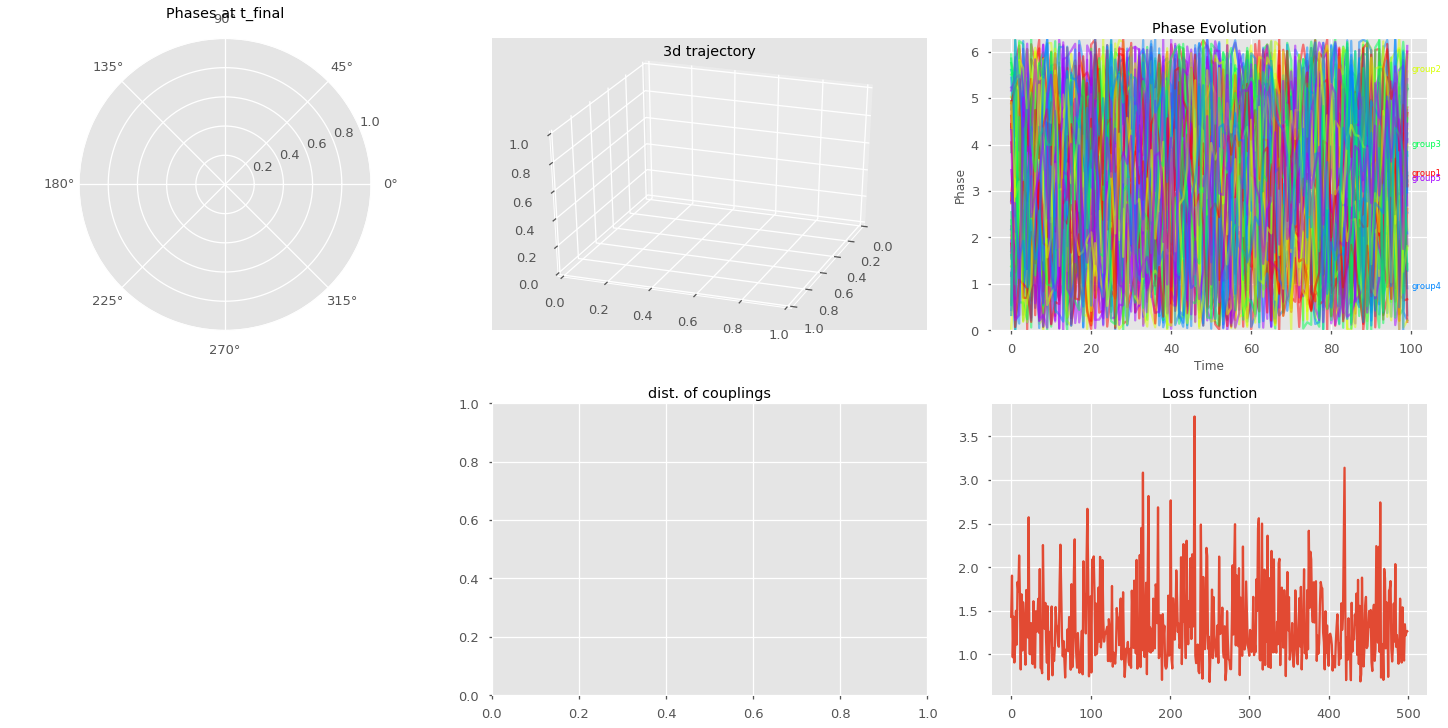

In [46]:
#init_phase = Trainer.init
a = Trainer.batch
idx = Trainer.idx
perturbation = dict(zip([0],[0]))
#perturbation = dict(zip([1001,3000,5000],[torch.normal(0,0.5,(n_nodes,)).float().unsqueeze(0) for i in range(3)]))
#Trainer.run_perturbation(perturbations=perturbation,kuramoto_steps=100)
#Trainer.run(kuramoto_steps=500)
phase = Trainer.phases
#phase1 = Trainer.phases.squeeze(1).detach().numpy()
#couplings = torch.stack(Trainer.couplings).reshape(500,15,15)
masks = Trainer.masks
ecolors = [cm.jet(x*10) for x in idx]

fig = plt.figure(figsize=(20,10),constrained_layout=True)
spec4 = fig.add_gridspec(ncols=3, nrows=2)
ax = fig.add_subplot(spec4[0, 0], polar=True)
ax.set_title('Phases at t_final')
#ax.scatter(phase[-1].squeeze(0).detach().numpy(), np.ones(len(idx)), c=idx, alpha=0.75)
ax = fig.add_subplot(spec4[0, 1], projection='3d')
ax.set_title('3d trajectory')
#ax.plot(np.cos(phase1[:,0]), np.cos(phase1[:,1]), np.cos(phase1[:,2]))
ax.view_init(elev=30, azim=20)
ax = fig.add_subplot(spec4[1,1])
ax.set_title('dist. of couplings')
#mean = torch.pow(couplings,2).mean((1,2)).detach().numpy()
#std = torch.pow(couplings,2).std((1,2)).detach().numpy()
#ax.plot(mean)
#ax.fill_between(np.arange(500),mean-std,mean+std,alpha=0.4)
ax = fig.add_subplot(spec4[0,2])
phase_evol_ax(ax,phase,masks.unsqueeze(0).data.numpy())
ax = fig.add_subplot(spec4[1,2])
ax.set_title('Loss function')
ax.plot(losses)
#plt.savefig('feedback control 3D',dpi=200)
plt.show()

# Distribution learning feedback

In [13]:
class KuraTrainer_feedback_distrib(object):
    
    def __init__(self, model, data_generator, LossFunc, num_out,
                          transform=None,kuramoto_steps=100, lr=.01, alpha=.1,
                          hidden_size =128, num_hid_layers=1,batch_size=256,optimizer='Adam',init_std=0.5,
                          view_connectivities=-1, feedback='full', verbose=1):
        
        super(KuraTrainer_feedback_distrib, self).__init__()
        self.data_generator = data_generator
        self.batch_size = batch_size
        self.LossFunc = LossFunc
        self.model = model
        self.verbose = verbose
        self.in_size = 100
        self.hidden_size = hidden_size 
        self.num_layers = num_hid_layers
        self.num_out = self.batch_size * self.batch_size
        self.transform=None
        self.kuramoto_steps=kuramoto_steps
        self.lr=lr
        self.alpha= alpha
        self.num_hid_layers=1,
        self.init_std = init_std
        
        self.GRU = (type(model) == KuraGRU)
        self.feedback = feedback

        #model and optimizer
        self.model = model
        if optimizer=='Adam':
            self.opt = torch.optim.Adam(self.model.parameters(), lr=lr)
        elif optimizer=='SGD':
            self.opt = torch.optim.SGD(self.model.parameters(), lr=lr)
                
    def init_phase(self,batch_size):
        self.init = torch.normal(np.pi,self.init_std,(batch_size,)).float().unsqueeze(0)
        return self.init
     
    def kuramoto_step(self, phase, coupling, omega):
        phase_diffs = torch.sin(phase.unsqueeze(-1) - phase.unsqueeze(-2))
        delta = self.alpha * (omega + (coupling * phase_diffs).sum(1))
        return phase + delta
                
    def train(self,gradient_steps=50, lr=0.1, normalized=False, eps=1e-12, num_loss=0, burn_in_prop=.5, omega_bool=False):
        
            self.losses = []
            self.init_phase(self.batch_size)
            
            for i in range(gradient_steps):
                
                #The graph definition is changing per batch
                with torch.no_grad():
                    batch, idx = self.data_generator.sample(self.batch_size)
                    self.batch = batch.float()
                    self.idx = idx.float()
                    self.masks = torch.FloatTensor(self.batch_size,self.data_generator.n_components).zero_()
                    self.masks.scatter_(1,idx.unsqueeze(1),1).transpose_(1,0)
                if omega_bool == False:
                    omega = torch.zeros((self.batch_size,)).float()
                else:
                    omega = torch.FloatTensor((self.batch_size,)).uniform_(0,1)
                
                start = time.time()
                self.phase_trajectory = []
                self.couplings = []
                    
                #Initial parameters
                self.init_phase(self.batch_size)
                phase = self.init
                self.phase_trajectory.append(phase)
                
                if self.feedback == 'full':
                    for j in range(self.kuramoto_steps):
                    #for j in range(np.random.randint(low=50, high=150)):

                        #Update functions
                        x_in = torch.cat([self.batch.reshape(1,-1),phase],1)
                        out = self.model(x_in).reshape(1,self.batch_size,self.batch_size)
                        phase = self.kuramoto_step(phase, out, omega)
                        #Bookkeeping
                        self.phase_trajectory.append(phase)      
                        self.couplings.append(out) 
                elif self.feedback in ['perturbation',False]:
                    x_in = torch.cat([self.batch.reshape(1,-1),phase],1)
                    out = self.model(x_in).reshape(1,self.batch_size,self.batch_size)
                    for j in range(self.kuramoto_steps):
                        phase = self.kuramoto_step(phase, out, omega)
                        #Bookkeeping
                        self.phase_trajectory.append(phase)      
                        self.couplings.append(out) 
                    
                flow = torch.stack(self.couplings).detach()
                phases = torch.stack(self.phase_trajectory)
                
                #Loss computation
                loss = self.LossFunc(phases,self.masks,split=True, burn_in_prop=burn_in_prop)
                loss[num_loss].backward()
                self.phases = phases.detach()
                self.losses.append(loss[num_loss].detach().cpu().numpy())
                self.opt.step()
                self.opt.zero_grad()
                stop = time.time()
                
                if self.verbose:
                    print('Iteration {}. Loss: {}. Time/flow: {}'.format(i, self.losses[-1], stop-start))

                #if cv != cv:
                #    ipdb.set_trace()

            return self.losses
        
    def run(self,kuramoto_steps=50, normalized=False,num_loss=0,burn_in_prop=.5):

        start = time.time()
        self.phase_trajectory = []
        self.couplings = []
        #with torch.no_grad():
        #    batch, idx = self.data_generator.sample(self.batch_size)
        #    self.batch = batch.float()
        #    self.idx = idx.float()
        #    self.masks = torch.FloatTensor(self.batch_size,self.data_generator.n_components).zero_()
        #    self.masks.scatter_(1,idx.unsqueeze(1),1).transpose_(1,0)

        #Initial parameters
        self.init_phase(self.batch_size)
        phase = self.init  
        omega = torch.zeros_like(phase)
        self.phase_trajectory.append(phase)

        if self.feedback == 'full':
            for j in range(kuramoto_steps):
                x_in = torch.cat([self.batch.reshape(1,-1),phase],1)
                out = self.model(x_in).reshape(1,self.batch_size,self.batch_size)
                phase = self.kuramoto_step(phase, out, omega)
                #Bookkeeping
                self.phase_trajectory.append(phase)      
                self.couplings.append(out) 
        elif self.feedback in ['perturbation',False]:
            out = self.model(phase).reshape(1,self.batch_size,self.batch_size)
            for j in range(kuramoto_steps):
                phase = self.kuramoto_step(phase, out, omega)
                #Bookkeeping
                self.phase_trajectory.append(phase)      
                self.couplings.append(out) 
            

        self.flow = torch.stack(self.couplings).detach()
        self.phases = torch.stack(self.phase_trajectory).detach()

        #Loss computation
        loss = self.LossFunc(self.phases,self.masks,split=True, burn_in_prop=burn_in_prop)
        stop = time.time()
        
        return loss
            

    def run_perturbation(self,perturbations,kuramoto_steps=50,num_loss=0):

        start = time.time()
        self.phase_trajectory = []
        self.couplings = []
        with torch.no_grad():
            batch, idx = self.data_generator.sample(self.batch_size)
            self.batch = batch.float()
            self.idx = idx.float()
            self.masks = torch.FloatTensor(self.batch_size,self.data_generator.n_components).zero_()
            self.masks.scatter_(1,idx.unsqueeze(1),1).transpose_(1,0)

        #Initial parameters
        self.init_phase(self.batch_size)
        phase = self.init  
        omega = torch.zeros_like(phase)
        self.phase_trajectory.append(phase)

        
        if self.feedback:
            for j in range(kuramoto_steps):
            #for j in range(np.random.randint(low=50, high=150)):
                if j in perturbations.keys():
                    with torch.no_grad():
                        phase = phase + perturbations[j]

                #Update functions
                x_in = torch.cat([self.batch.reshape(1,-1),phase],1)
                out = self.model(x_in).reshape(1,self.batch_size,self.batch_size)
                phase = self.kuramoto_step(phase, out, omega)
                #Bookkeeping
                self.phase_trajectory.append(phase)      
                self.couplings.append(out) 
        elif self.feedback == 'perturbation':
            out = self.model(phase).reshape(1,self.batch_size,self.batch_size)
            for j in range(kuramoto_steps):
                if j in perturbations.keys():
                    with torch.no_grad():
                        phase = phase + perturbations[j]
                    out = self.model(phase).reshape(1,self.batch_size,self.batch_size)
                        
                phase = self.kuramoto_step(phase, out, omega)
                #Bookkeeping
                self.phase_trajectory.append(phase)      
                self.couplings.append(out) 
        elif self.feedback == False:
            out = self.model(phase).reshape(1,self.batch_size,self.batch_size)
            for j in range(kuramoto_steps):
                if j in perturbations.keys():
                    with torch.no_grad():
                        phase = phase + perturbations[j]
                        
                phase = self.kuramoto_step(phase, out, omega)
                #Bookkeeping
                self.phase_trajectory.append(phase)      
                self.couplings.append(out) 


        self.flow = torch.stack(self.couplings).detach()
        self.phases = torch.stack(self.phase_trajectory).detach()

        #Loss computation
        loss = self.LossFunc(self.phases,self.masks,split=True, burn_in_prop=.19)
        stop = time.time()
        

        return loss

In [16]:
# Training parameters
seed = 4
np.random.seed(seed)
torch.manual_seed(seed)
n_nodes=50
n_groups = 10
transform=None
num_hid_units= 200
num_hid_layers = 2
kuramoto_steps= 100
alpha = 0.1
lr=1e-4
optimizer='Adam'
init_std = 1



num_in = n_nodes + 2*n_nodes
hidden_size = 100
num_out = n_nodes*n_nodes

model = connectivity_net(num_in, num_out, num_hid_units=num_hid_units, num_hid_layers=num_hid_layers,transform=transform,gain=0.5)
#data_generator = Spirals(noise = 0.5)
data_generator = GMM(n_components=5, centroids=[[3,-3],[4,8],[-3,3],[-2,-5],[0,10]], cov_matrices=20*np.array([0.05*np.eye(2),0.02*np.diag([1,5]),0.02*np.eye(2),0.01*np.eye(2),0.01*np.eye(2)]))
LossFunc = circular_moments_batch
Trainer =  KuraTrainer_feedback_distrib(model, 
                          data_generator, 
                          LossFunc,
                          num_out,  
                          batch_size=n_nodes,
                          transform=transform,
                          alpha=alpha,
                          lr=lr,
                          kuramoto_steps=kuramoto_steps,
                          num_hid_layers=num_hid_layers,
                          optimizer=optimizer,
                          verbose=1,
                          init_std=init_std,
                          feedback='full')

losses = Trainer.train(gradient_steps = 1000,num_loss=0, burn_in_prop=0.99,omega_bool=True)

Iteration 0. Loss: 2.0942342281341553. Time/flow: 0.4424443244934082
Iteration 1. Loss: 1.6666672229766846. Time/flow: 0.2970881462097168
Iteration 2. Loss: 1.381723403930664. Time/flow: 0.4258720874786377
Iteration 3. Loss: 1.0652328729629517. Time/flow: 0.4158935546875
Iteration 4. Loss: 0.7164657115936279. Time/flow: 0.38990330696105957
Iteration 5. Loss: 2.062757968902588. Time/flow: 0.407761812210083
Iteration 6. Loss: 2.399747371673584. Time/flow: 0.4526965618133545
Iteration 7. Loss: 1.0404620170593262. Time/flow: 0.471621036529541
Iteration 8. Loss: 0.9059432744979858. Time/flow: 0.40392374992370605
Iteration 9. Loss: 1.099747657775879. Time/flow: 0.44090986251831055
Iteration 10. Loss: 1.9887661933898926. Time/flow: 0.35632967948913574
Iteration 11. Loss: 1.1204066276550293. Time/flow: 0.38520097732543945
Iteration 12. Loss: 1.2811049222946167. Time/flow: 0.40521955490112305
Iteration 13. Loss: 2.2578439712524414. Time/flow: 0.3846440315246582
Iteration 14. Loss: 2.19752287864

KeyboardInterrupt: 

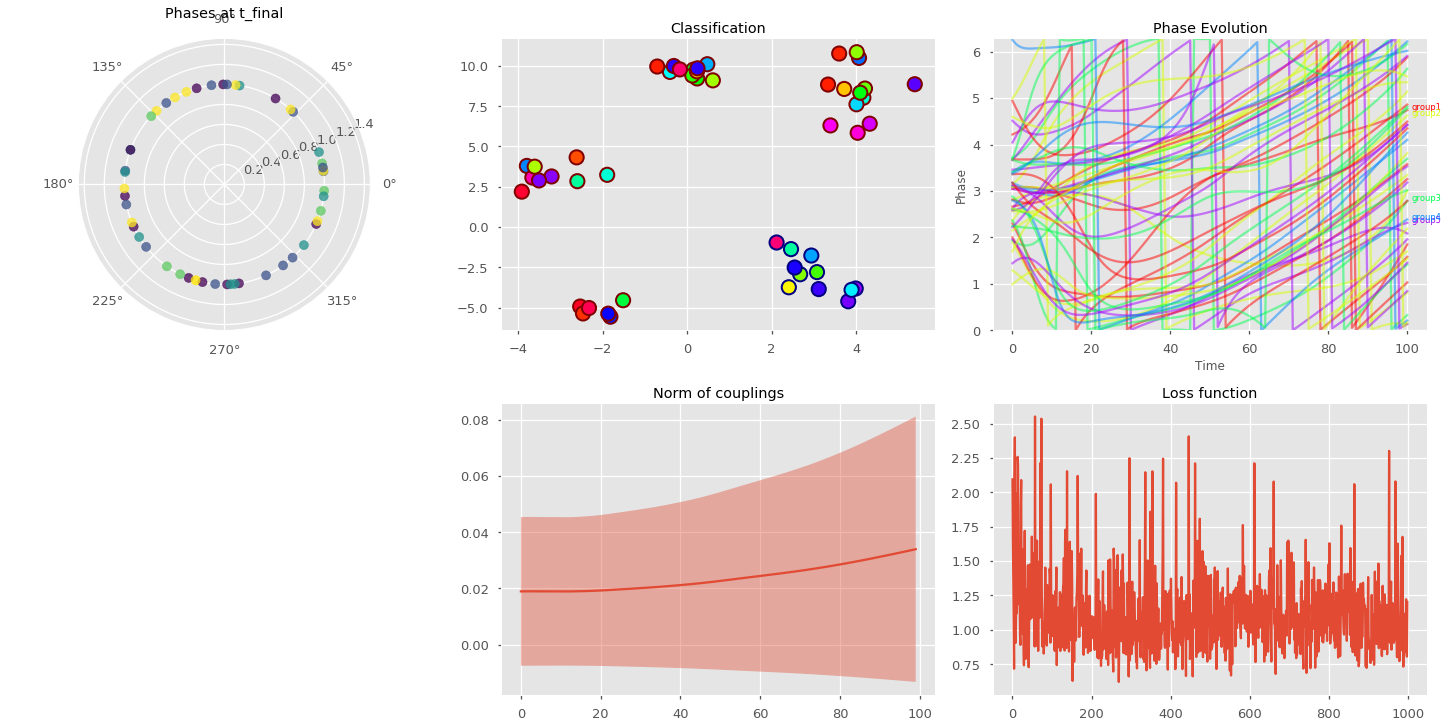

In [35]:
init_phase = Trainer.init_phase(Trainer.batch_size)
a = Trainer.batch
idx = Trainer.idx
#perturbation = dict(zip([],[]))
#perturbation = dict(zip([3000,6000],[torch.normal(0,1,(n_nodes,)).float().unsqueeze(0) for i in range(2)]))
#Trainer.run_perturbation(perturbations=perturbation,kuramoto_steps=10000)
phase = Trainer.phases
phase1 = Trainer.phases.squeeze(1).detach().numpy()
couplings = torch.stack(Trainer.couplings).reshape(100,50,50)
masks = Trainer.masks
ecolors = [cm.jet(x*10) for x in idx]

fig = plt.figure(figsize=(20,10),constrained_layout=True)
spec4 = fig.add_gridspec(ncols=3, nrows=2)
ax = fig.add_subplot(spec4[0, 0], polar=True)
ax.set_title('Phases at t_final')
ax.scatter(phase[-1].squeeze(0).detach().numpy(), np.ones(len(idx)), c=idx, alpha=0.75)
ax = fig.add_subplot(spec4[0, 1])
ax.set_title('Classification')
ecolors = [cm.jet(x*10) for x in idx]
colors = [cm.hsv(x) for x in (phase[-1].squeeze().detach().numpy()%(2*np.pi))/(2*np.pi)]
ax.scatter(a[:,0],a[:,1],c=colors,edgecolors=ecolors,linewidth=2,s=200)
ax = fig.add_subplot(spec4[1,1])
ax.set_title('Norm of couplings')
mean = torch.pow(couplings,2).mean((1,2)).detach().numpy()
std = torch.pow(couplings,2).std((1,2)).detach().numpy()
ax.plot(mean)
ax.fill_between(np.arange(100),mean-std,mean+std,alpha=0.4)
ax = fig.add_subplot(spec4[0,2])
phase_evol_ax(ax,phase.detach(),masks.unsqueeze(0).data.numpy())
ax = fig.add_subplot(spec4[1,2])
ax.set_title('Loss function')
ax.plot(losses)
#plt.savefig('circles classification',dpi=200)
plt.show()

## Control module learning

In [38]:
class connectivity_net_v2(torch.nn.Module):
    def __init__(self, num_in, num_out, num_hid_units=256, num_hid_layers=1,transform=None,gain=1.):
        super(connectivity_net_v2, self).__init__()
        self.transform=transform
        self.num_out = num_out
        self.gain = gain
        self.layers = torch.nn.ModuleList([torch.nn.Linear(num_in, num_hid_units),
                         torch.nn.ReLU()])
        for _ in range(num_hid_layers):
            self.layers.extend([torch.nn.Linear(num_hid_units, num_hid_units),torch.nn.ReLU()])
        self.layers.append(torch.nn.Linear(num_hid_units,self.num_out))
            
        self.model_names = [item[0] for item in filter(lambda p: p[1].requires_grad, self.named_parameters())]
            
    def forward(self,x):   
        for layer in self.layers:
            x = layer(x) 
        if self.transform == 'softmax':
            x = softmax(x,dim=-1)
        elif self.transform == 'sigmoid':
            x = sigmoid(x)  
        elif self.transform == 'Tanh':
            x = torch.tanh(x)
        else:
            #x = x/torch.pow(torch.pow(x,2).sum(-1),0.5).unsqueeze(1) - 0.5
            #x = (x - x.mean(1).unsqueeze(1))/x.std(1).unsqueeze(1)
            x = x #- 0.5
        return x
    
    def get_weight_cardinals(self):
        model_parameters = filter(lambda p: p.requires_grad, self.parameters())
        params = [p.size() for p in model_parameters]
        self.weights_cardinals = params
        return 
    
    def update(self, weights):
        weights = [weights[i].reshape(shape) for i, shape in enumerate(self.weights_cardinals)]
        state_dict = OrderedDict(zip(self.model_names,weights))
        self.load_state_dict(state_dict)
        return
    
########################################################################################################################################################
    
class Control_MLP(torch.nn.Module):
    def __init__(self, num_in, num_out, numbers_weights, device, num_hid_units=256, num_hid_layers=1,transform=None,gain=1.):
        super(Control_MLP, self).__init__()
        self.transform=transform
        self.num_out = num_out
        self.gain = gain
        self.device = device
        self.numbers_weights = numbers_weights
        
        #Multi-head control instanciation
        self.layers = torch.nn.ModuleList([torch.nn.Linear(num_in, num_hid_units),torch.nn.ReLU()])
        for _ in range(num_hid_layers):
            self.layers.extend([torch.nn.Linear(num_hid_units, num_hid_units),torch.nn.ReLU()])
        self.control_read_outs = nn.ModuleList([nn.Linear(num_hid_units,w).to(device) for w in self.numbers_weights])
        self.layers
        
        for layer in self.layers:
            try :
                #torch.nn.init.orthogonal_(layer.weight, gain=self.gain)
                #torch.nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='tanh')
                torch.nn.init.xavier_normal_(layer.weight, gain=self.gain)
                #torch.nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='tanh')
            except:
                pass
            
    def forward(self,x):  
        weights = []
        for layer in self.layers:
            x = layer(x)
        for layer in self.control_read_outs:
            weights.append(layer(x))
            
        #if self.transform == 'softmax':
        #    x = softmax(x,dim=-1)
        #elif self.transform == 'sigmoid':
        #    x = sigmoid(x)  
        #elif self.transform == 'Tanh':
        #    x = torch.tanh(x)

        return weights

In [40]:
class KuraTrainer_metacontrol(object):
        def __init__(self, feedbackmodel, data_generator, batch_size, LossFunc,alpha=0.1, lr=1e-4, verbose=0, kuramoto_steps=200,init_std=0.5):
            super(KuraTrainer_metacontrol, self).__init__()
            self.data_generator = data_generator
            self.batch_size = batch_size
            self.LossFunc = LossFunc
            self.feedbackmodel = feedbackmodel
            self.device = torch.device('cpu')
            self.alpha = alpha
            self.verbose = verbose
            self.kuramoto_steps=kuramoto_steps
            self.lr=lr
            self.alpha= alpha
            self.init_std = init_std

            
        def init_phase(self,batch_size):
            #self.init = torch.zeros((batch_size,)).float().unsqueeze(0)
            self.init = torch.normal(np.pi,self.init_std,(batch_size,)).float().unsqueeze(0)
            #self.init = torch.FloatTensor(batch_size,).uniform_(0, 2*np.pi).unsqueeze(0)
            return self.init
            #return torch.normal(np.pi,0.05,(batch_size,)).float().unsqueeze(0)
        
        def plot_data(self,num_points):
            a, idx = self.data_generator.sample(num_points)
            plt.scatter(a[:,0],a[:,1],c=idx)
            plt.show()
            
        def kuramoto_step(self, phase, coupling, omega):
            phase_diffs = torch.sin(phase.unsqueeze(-1) - phase.unsqueeze(-2))
            delta = self.alpha * (omega + (coupling * phase_diffs).sum(1))
            return phase + delta
        
        def train(self,gradient_steps=50,lr=0.1, alpha=.1, normalized=False, eps=1e-12,num_loss=0,burn_in_prop=.5, verbose=0):
            
            self.losses = []
            
            #define feedback and control models
            self.feedbackmodel.get_weight_cardinals()
            self.weights_cardinals = [np.prod(shape) for shape in self.feedbackmodel.weights_cardinals]
            self.controller = Control_MLP(num_in, num_out, self.weights_cardinals, self.device, num_hid_units=256, num_hid_layers=1,transform=None,gain=0.5)
            
            opt = torch.optim.Adam(self.controller.parameters(), lr=self.lr)

            for _ in range(gradient_steps):
                
                self.phase_trajectory = []
                self.couplings = []

                if _ > 0 or _ == 0:
                    with torch.no_grad():
                        batch, idx = self.data_generator.sample(self.batch_size)
                        self.batch = batch.float().reshape(1,-1)
                        self.idx = idx.float()
                        self.masks = torch.FloatTensor(self.batch_size,self.data_generator.n_components).zero_()
                        self.masks.scatter_(1,idx.unsqueeze(1),1).transpose_(1,0)
                phase = self.init_phase(self.batch_size) #self.init_phase(self.batch_size)
                omega = torch.zeros_like(phase)
                    

                #Training by gradient descent via adjoint sensitivity method
                start = time.time()
                
                #Controller instanciation
                self.weights = self.controller(self.batch)
                self.feedbackmodel.update(self.weights)
            
                
                #Flow integration
                out = self.feedbackmodel(phase).reshape(1,self.batch_size,self.batch_size)
                for j in range(self.kuramoto_steps):
                    #out = self.feedbackmodel(phase).reshape(1,self.batch_size,self.batch_size)
                    phase = self.kuramoto_step(phase, out, omega)
                    #print(phase)
                    #print("\n")
                    #Bookkeeping
                    self.phase_trajectory.append(phase)      
                    self.couplings.append(out) 
            

                self.flow = torch.stack(self.couplings)
                self.phases = torch.stack(self.phase_trajectory)

                #Loss computation
                loss = self.LossFunc(self.phases ,self.masks, split=True, burn_in_prop=burn_in_prop)
                self.losses.append(loss[num_loss].detach().numpy())
                loss[num_loss].backward(retain_graph=True)
                
                #Control graident propagation
                for i, parameters in enumerate(self.feedbackmodel.parameters()):
                    self.weights[i].backward(gradient=parameters.grad.reshape(1,-1),retain_graph=True)
                #print(self.controller.layers[0].weight.grad.sum())
                opt.step()
                opt.zero_grad()

                stop = time.time()
                
                if self.verbose:
                    print('Iteration {}. Loss: {}. Time/flow: {}'.format(_, self.losses[-1], stop-start))
                    
                
            return self.losses

In [41]:
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)
n_nodes=50
n_groups =5
num_hid_units= 50
num_hid_layers = 1
kuramoto_steps= 200
alpha = 0.05
lr=1e-4
optimizer='Adam'
init_std = 0.1
gain=0.1



num_in = 2*n_nodes #+ 2*batch_size
hidden_size = 100
num_out = n_nodes*n_nodes


Model = connectivity_net_v2(n_nodes, num_out, num_hid_units=num_hid_units, num_hid_layers=num_hid_layers,transform=None,gain=gain)
gmm = GMM(n_components=5, centroids=[[3,-3],[4,8],[-3,3],[-2,-5],[0,10]], cov_matrices=20*np.array([0.05*np.eye(2),0.02*np.diag([1,5]),0.02*np.eye(2),0.01*np.eye(2),0.01*np.eye(2)]))
LossFunc = circular_moments_batch
Trainer = KuraTrainer_metacontrol(Model, gmm, LossFunc=LossFunc, batch_size=n_nodes, alpha=alpha, lr=lr, verbose=1, kuramoto_steps=kuramoto_steps,init_std=init_std)


Trainer.train(gradient_steps=1000,lr=lr,num_loss=0, burn_in_prop=.99, verbose=1)

Iteration 0. Loss: 1.1191589832305908. Time/flow: 0.5172913074493408
Iteration 1. Loss: nan. Time/flow: 0.4814574718475342
Iteration 2. Loss: nan. Time/flow: 0.4899594783782959
Iteration 3. Loss: nan. Time/flow: 0.5084609985351562
Iteration 4. Loss: nan. Time/flow: 0.49361515045166016
Iteration 5. Loss: nan. Time/flow: 0.5186409950256348
Iteration 6. Loss: nan. Time/flow: 0.549025297164917


KeyboardInterrupt: 

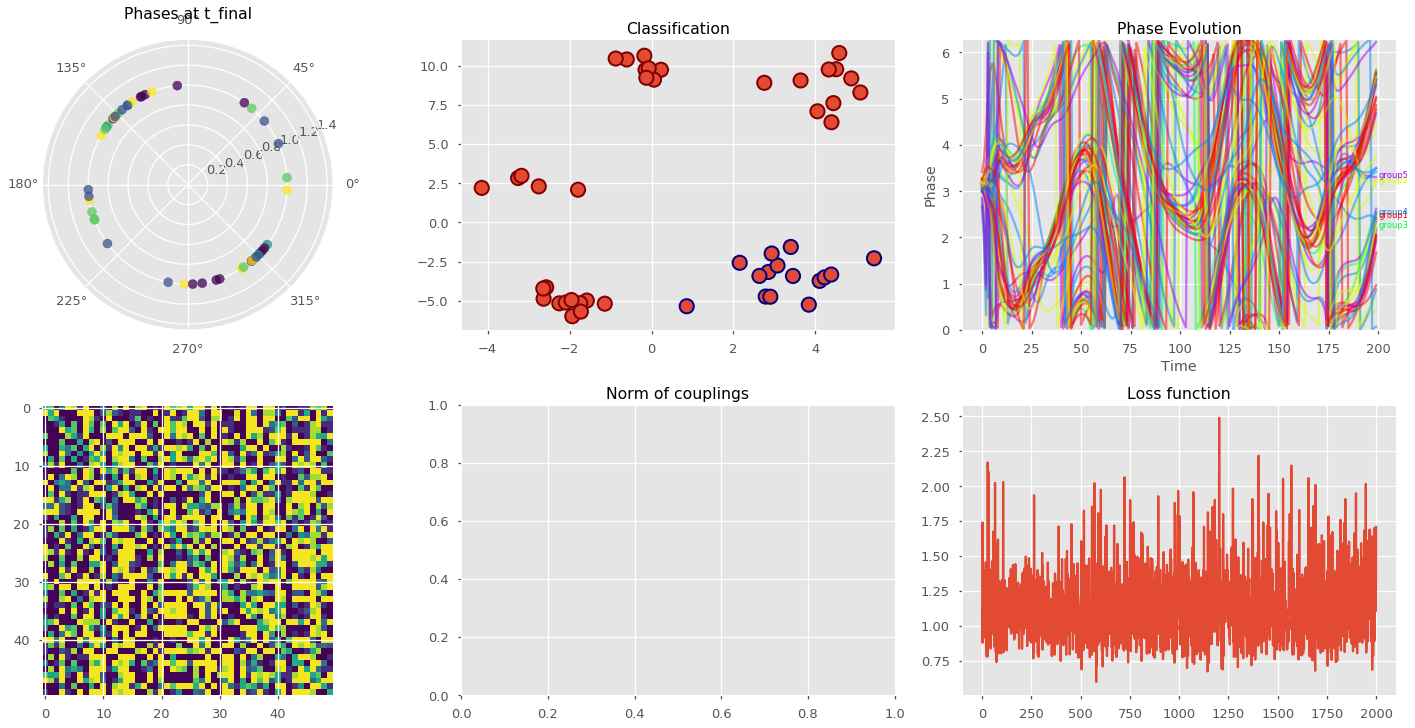

In [36]:
init_phase = Trainer.init_phase(Trainer.batch_size)
a = Trainer.batch.reshape(Trainer.batch_size,-1)
idx = Trainer.idx
#perturbation = dict(zip([],[]))
#perturbation = dict(zip([3000,6000],[torch.normal(0,1,(n_nodes,)).float().unsqueeze(0) for i in range(2)]))
#Trainer.run_perturbation(perturbations=perturbation,kuramoto_steps=10000)
phase = Trainer.phases
phase1 = Trainer.phases.squeeze(1).detach().numpy()
couplings = torch.stack(Trainer.couplings).reshape(200,50,50)
masks = Trainer.masks
ecolors = [cm.jet(x*10) for x in idx]
colors = [cm.hsv(x) for x in (phase[-1].squeeze().detach().numpy()%(2*np.pi))/(2*np.pi)]

fig = plt.figure(figsize=(20,10),constrained_layout=True)
spec4 = fig.add_gridspec(ncols=3, nrows=2)
ax = fig.add_subplot(spec4[0, 0], polar=True)
ax.set_title('Phases at t_final')
ax.scatter(phase[-1].squeeze(0).detach().numpy(), np.ones(len(idx)), c=idx, alpha=0.75)
ax = fig.add_subplot(spec4[0, 1])
ax.set_title('Classification')
ecolors = [cm.jet(x*10) for x in idx]
colors = [cm.hsv(x) for x in (phase[-1].squeeze().detach().numpy()%(2*np.pi))/(2*np.pi)]
ax.scatter(a[:,0],a[:,1],edgecolors=ecolors,linewidth=2,s=200)
ax = fig.add_subplot(spec4[1,0])
ax.imshow(couplings[-1].detach().numpy())
ax = fig.add_subplot(spec4[1,1])
ax.set_title('Norm of couplings')
#mean = torch.pow(couplings,2).mean((1,2)).detach().numpy()
#std = torch.pow(couplings,2).std((1,2)).detach().numpy()
#ax.plot(mean)
#ax.fill_between(np.arange(100),mean-std,mean+std,alpha=0.4)
ax = fig.add_subplot(spec4[0,2])
phase_evol_ax(ax,phase.detach(),masks.unsqueeze(0).data.numpy())
ax = fig.add_subplot(spec4[1,2])
ax.set_title('Loss function')
ax.plot(Trainer.losses)
#plt.savefig('circles classification',dpi=200)
plt.show()

In [37]:
Trainer.couplings[-1]

tensor([[[ 0.2881,  0.5863, -1.1162,  ...,  0.5843,  0.9146, -1.0998],
         [ 1.1514,  0.2953,  1.1683,  ...,  1.1682, -0.8402,  1.1723],
         [-1.1174,  0.5829,  0.2903,  ...,  1.1680,  0.2907, -0.5486],
         ...,
         [ 1.1673,  0.8822, -0.8348,  ...,  0.2902,  1.1826,  1.1678],
         [-1.1371, -1.1153, -1.1249,  ...,  1.1691,  0.2983, -0.8284],
         [-0.8076, -1.1292, -1.1153,  ..., -1.1143, -1.1279,  0.2954]]],
       grad_fn=<AsStridedBackward>)